In estimating AvNLL (or perplexity or mean probability) ... the question is what 'n' to take.
This can be error prone, and we don't want to constantly re-score the quotation, so...

    use snellius to get a bunch of sentence, gpt-2 tokens, chained scores for each quote ... from which we can group into 'words' 
    retrospectively



In [5]:
#pip install "numpy<2"  # handles the arviz import error

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.1
    Uninstalling numpy-2.0.1:
      Successfully uninstalled numpy-2.0.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pathlib
import re
from tqdm import tqdm
import typing
from pprint import pprint as pp
import json
from nltk.tokenize import WhitespaceTokenizer, word_tokenize
import arviz as az
import numpy as np
from collections import Counter
import pathlib
import pandas as pd
from itertools import permutations

tqdm.pandas()

In [2]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import arviz as az
import pymc as pm


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load the quotes

## Get the subset with less than 1024 tokens, corresponding to the GPT2 chain output

In [3]:
with open('../extract_quotes_via_spaCy/quotes_5Jul/quotes_blacklist.json', 'r') as f:
    blacklist = json.load(f)  # i.e., quotes indices for which len(span) > 1024; thus, 

In [4]:
with open('../extract_quotes_via_spaCy/quotes_5Jul/quotes_5Jul.json', 'r') as f:
    quotes = df = pd.DataFrame([t for i,t in enumerate(json.load(f)) if i not in blacklist], columns = ["id", "p", "quote", "manner", "speaker"])

In [5]:
list(quotes.loc[quotes.loc[:,"speaker"].isin(['negro', 'Negro']),"quote"])

['"Howdy, Marse Stephen,"',
 '"I seed yo\' ma yestiddy en she sutney wuz lookin well an\' peart."',
 '"None, suh?"',
 '"Well, suh,"',
 '"Dey won\'t find \'em,"',
 '"I\'m coming, suh!"',
 '"Yes, mistis,"',
 '"I ain\'t a gwine to stay here, missis,"',
 '"for any money in dis world, and if dey wont let me go out wid you, I will come arter you by myself."',
 '"His name is Mr. Alfred Wentworth,"',
 '"Top a bit, mistis, an\' I will fix de little gal for you,"',
 '"Dar now,"',
 '"did not I tell you dat de sweet little child was libbing."',
 '"What make you come to dis part ob town to-night, missis,"',
 '"I don\'t know, but I spect it will do,"',
 '"Don\'t cry chile,"',
 '"Dat\'s a good gal,"',
 '"you tell him dat I want to see him, but don\'t tell him what I want him for--I rader tell him dat mysef."',
 '"Jes de lubliest baby you eber seed in your life,"',
 '"Why de lady and childen dat come to my cabin was from New Orleans too,"',
 '"Dat\'s it,"',
 '"dat\'s de berry name!"',
 '"Poh lady,"',


# Load the GPT-2 chained probabilities wrt., tokenized quotes (sans blacklist)

In [6]:
chains_dir = pathlib.Path('../chains/quotes_5Jul/124M/')

# get orders list of chains fps - they need to be re-assembled in this order, to correspond to 
ordered_chains_fps = sorted(list(chains_dir.glob('*.json')), key=lambda c: int(re.search(r"_(\d+)\.json", str(c)).groups()[0]))

# re-assemble
chains = []
for chain_fp in tqdm(ordered_chains_fps):
    with open(chain_fp, 'r') as f:
        chains += json.load(f)

100%|██████████████████████████████████████████████████████████████████████| 75/75 [00:16<00:00,  4.51it/s]


In [7]:
# chains - quotes
len(chains) - len(quotes)

0

## test our chains

*do sampled chains (collected on server), approximately equal chains for sample indices produced locally?*

In [7]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [8]:
def get_chains(quotes: list[str], tokenizer, model):
    """
    get the chained probabilities wrt., each span, i.e.: torch.tensor([P(w1), P(w2|w1), P(w3|w1,w2), ...])
    """
    spans = quotes
    
    # encode the spans
    spans_ids = [tokenizer.encode(span) for span in spans]

    # add padding
    max_length = max([len(span_ids) for span_ids in spans_ids])
    pad_token_id = tokenizer.eos_token_id
    input_ids = torch.tensor(
        [
            span_ids + [pad_token_id] * (max_length - len(span_ids))
            for span_ids in spans_ids
        ]
    )

    # create attention mask
    attention_mask = torch.tensor(
        [
            [0 if token_id == pad_token_id else 1 for token_id in span_ids]
            for span_ids in input_ids
        ]
    )

    # get the chained proababilities
    with torch.no_grad():

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        # logits.shape = (|batch size|, |tokens|, |vocab|)

        probs = F.softmax(logits, dim=-1)  # transfer to gpu

        chains = [
            [probs[i][j][id_] for j, id_ in enumerate(span_ids)]
            for i, span_ids in enumerate(spans_ids)
        ]

    return chains


# Load the tokenizer

In [9]:
tk = WhitespaceTokenizer()
whitespace_tokenize = tk.tokenize

# Measuring surprise with GPT-2 and analysing with pymc

In [10]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import arviz as az

In [11]:
# how big is the loaded model?
sum(p.numel() for p in model.parameters() if p.requires_grad)

124439808

In [13]:
## let's double check how the tokenizer handles various examples of punctation ...

# note: the tokenizer tokenizes, and there's nothing we can do about those 
#       subtoken choices. However, what's important to us is that we correctly
#       partition them into 'words', for perplexity calculations

test_cases = [
    '"Howdy, Marse Stephen,"',
    "what is this life (if full of care).",
    "what is this life [if full of care].",
    "what is this life {if full of care}.",
    "what is this life, if full of care.",
    "what is this life, if full of care?",
    "what is this life, if full of care!",
    "what is this life: if full of care.",
    "what is this life; if full of care.",
    "what is this life ... if full of care.",
    "what is this,(life) ... if full of care.",
]

for test_case in test_cases:
    print(test_case)
    print('\t' + str(tokenizer.tokenize(test_case)))

"Howdy, Marse Stephen,"
	['"', 'How', 'dy', ',', 'ĠMarse', 'ĠStephen', ',"']
what is this life (if full of care).
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ(', 'if', 'Ġfull', 'Ġof', 'Ġcare', ').']
what is this life [if full of care].
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ[', 'if', 'Ġfull', 'Ġof', 'Ġcare', '].']
what is this life {if full of care}.
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ{', 'if', 'Ġfull', 'Ġof', 'Ġcare', '}.']
what is this life, if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this life, if full of care?
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '?']
what is this life, if full of care!
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '!']
what is this life: if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ':', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this life; if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ';', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this 

Re. above ...
    
tokens may or may not be part a new word ... hence why Ġ is used.

Our stragegy for punctuation is as follows:

* ' or - is a continuation of the previous word part.
    
* every other punctation is a new word

Thus, we must account for this separately since GPT does not indicate this.

Also, we see instances ').' being lumped as a unit ... we accept this, since i) it's rare presumably in quotations

In [17]:
whitespace_tokenize("I jes’ want")

['I', 'jes’', 'want']

In [12]:
def get_words(s:str)->list[str]:
    """ split into words, ensure that contractions aren't split
        Note: This is my N wrt., 
        Note: why not word_tokenize() ? ... because it splits contractions
    """

    # split on whitespace
    words = whitespace_tokenize(s)

    # split of multiple hyphens, elipses, honorifics, initial (followed by dot), non alphanumeric/hyphen/apostrophe
    words_ = []
    for word in words:
        words_ += re.split(r"(-{2,}|\.\.\.|Mr\.|Mrs\.|Dr\.|Prof\.|[A-Z]\.|[^A-Za-z0-9-'’]+)", word)
    words = words_

    # split blocks of consecutive punctuation
    words_ = []
    for word in words:
        if re.match(r"[^A-Za-z0-9-']+", word) and not re.match(r"(\.\.\.|-{2,})", word):
            words_ += list(word)
        else:
            words_ += [word]
    words = words_

    # finally, remove empty strings
    words = [word for word in words if word != ""]

    return words

def get_words_indices(words, tokens):
    """ Return [list of token indices in first 'word', list of token indices in 2nd 'word', ...]

        Args:
            words (list[str]): reference list of 'words'
            tokens (list[str]): GPT-2 tokenizer tokens

        Sometimes we see the GPT-2 tokenizer fail to split consecutive punctuation, e.g., ")," ... since there's no way to split it ... we don't! 
        i.e., we return a list of indices which for that case contains 2 words ... this is not a problem, since we can just them in post-processing

        N is a count of the number of 'true words' in the words_indices, so we can perform this post processing adjustment

    """
    words_indices = []

    ti = 0  # token index
    wi = 0  # word index
    while wi < len(words) and ti < len(tokens):
        
        words_indices.append([])  # ready the container next set of indices
        
        to_fill = len(words[wi])

        # fill the 'word' indices with available token indices while ... 
        while to_fill > 0:
            
            # add token index to word indices
            words_indices[-1].append(ti)
            to_fill -= len(tokens[ti].strip("Ġ"))
            ti+=1

            # where the addition of tokens results in a negative remaining word length, 
            # add another word to current word ...
            while to_fill < 0:
                wi += 1 
                to_fill += len(words[wi])

        wi+=1 
            
    return words_indices, len(words_indices)


In [19]:
# where does this fail ... looks like encoding errors

errors = []
for i, quote in tqdm(enumerate(list(quotes['quote']))):

    try:
        s  = quote[1:-1]
        words = get_words(s)
        tokens = np.array(tokenizer.tokenize(s))
        words_indices, N = get_words_indices(words, tokens)
    except:
        errors.append(i)


2379076it [03:31, 11251.20it/s]


In [20]:
len(errors)

2352

In [21]:
# as a proportion ...
100*len(errors) / len(quotes)

0.09886191109489567

### ADD AvNLL scores to quotes
note: where error, instead add None

AvNLL = (1/N) sum_{links in chain} log(P(link))
exp(AvNLL) = perplexity = 1/P
P = exp(AvLL)

so maybe just logP

In [13]:
quotes["i"] = list(range(len(quotes)))

In [14]:
quotes["N"] = quotes["quote"].progress_apply(lambda x: len(get_words(x[1:-1])))

100%|█████████████████████████████████████████████████████████| 2379076/2379076 [00:54<00:00, 43599.85it/s]


In [15]:
quotes["AvNLL"] = quotes["i"].progress_apply(lambda i: -np.log(chains[i]).sum()/quotes["N"][i])

  3%|█▌                                                        | 64817/2379076 [00:00<00:16, 142045.76it/s]/var/folders/n9/04fxpc3d4dn4s513dwth10b80000gn/T/ipykernel_31332/2774228100.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  quotes["AvNLL"] = quotes["i"].progress_apply(lambda i: -np.log(chains[i]).sum()/quotes["N"][i])
 75%|█████████████████████████████████████████▉              | 1782153/2379076 [00:11<00:03, 157992.54it/s]/var/folders/n9/04fxpc3d4dn4s513dwth10b80000gn/T/ipykernel_31332/2774228100.py:1: RuntimeWarning: invalid value encountered in scalar divide
  quotes["AvNLL"] = quotes["i"].progress_apply(lambda i: -np.log(chains[i]).sum()/quotes["N"][i])
100%|████████████████████████████████████████████████████████| 2379076/2379076 [00:15<00:00, 151315.84it/s]


# RQs

In [16]:
# Plotting helper functions
# adapted from https://github.com/dustinstansbury/statistical-rethinking-2023/blob/main/Lecture%2004%20-%20Categories%20%26%20Curves.ipynb

# Note: use plot_posterior_estimates.py where only posterior plot wanted (faster)
def plot_posterior_trace(trace)->None:
    """ Plot:
            i) trace plots
            ii) posterior parameter distributions, i.e., P(parameter=value | data)

        Args:
            trace (arviz.data.inference_data.InferenceData)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])
        
        
def plot_posterior_estimates(trace, size: int = 1000, kind: str = "auto") -> dict:
    """Plot posterior parameter samples, i.e., P(parameter=value | data)

    Args:
        trace (arviz.data.inference_data.InferenceData)
        size (int): size of subsample to plot from complete set of posterior samples
            Note: max sample size of chains*draws (see trace.posterior)
        kind (str): arviz.plot_dist kind  (i.e., 'hist', 'kde', 'auto')

    Return a dict of posterior samples by parameters
    """
    # get the parameter names, for which there's a posterior est.
    var_names = [name for name in trace.posterior]

    # set up the plot
    fig, axs = plt.subplots((len(var_names)))
    fig.tight_layout()

    # MCMC samples the parameter space for all parameters simultaneously
    # we sample these (stacked) chain & draw instances
    # yields and xarray.core.dataset.Dataset, where sample_subset['param'] is a 1D array
    sample_subset = az.extract(trace, num_samples=size)  

    # for each parameter ... plot the sample_subset
    d = {}
    for i, (var_name) in enumerate(var_names):
        
        if len(var_names) > 1:
            plt.sca(axs[i])
        else:
            pass

        # get posterior samples wrt., var_name
        draw_samples = sample_subset[var_name]
        d[var_name] = draw_samples

        # get random samples of
        az.plot_dist(draw_samples, kind=kind, label=f"{var_name}")

    return d

import typing

import arviz as az
import matplotlib.pyplot as plt
import numpy as np


def plot_posterior_estimates_contrast(
    trace: az.data.inference_data.InferenceData,
    size: int = 1000,
    pairs: list[tuple] = [],
    kind: str = "auto",
) -> list:
    """ For each (param1::str, param2::str) pair in 'pairs' ...
        plot distribution of corresponding (param1 - param2) samples.

        where corresponding means the same chain&draw

        Args:
            trace ():
            size (int): sample size
                Note: max sample size of chains*draws (see trace.posterior)
            pairs (list[tuple]):
            kind (str):

        Returns a list of each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    # get sample_subset (of the posterior samples)
    #   yields xarray.core.dataset.Dataset object, where sample_subset['param'] is a 1D array
    sample_subset = az.extract(trace, num_samples=size)

    # init plot
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()

    # plot contrasts
    contrasts = []
    for i, (p1, p2) in enumerate(pairs):

        # get posterior contrast
        pc = sample_subset[p1] - sample_subset[p2]
        
        # set current subplot
        if len(pairs) > 1:
            plt.sca(axs[i])
        else:
            pass

        # plot
        az.plot_dist(pc, color=f"C{i}", kind=kind, label=f"{p1}-{p2}")

        # record the posterior contrast for the sample_subset, wrt., the pair
        contrasts.append(pc)

    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()

    return contrasts


def plot_posterior_predictive_overlay(model, trace, size=1000)->None:
    """ (density) plots of estimand predictions (based on parameter posteriors) against the observed

        Args:

            model (pymc.model.core.Model)
            trace (arviz.data.inference_data.InferenceData)
            size (int): the number of posterior predictions to obtain and plot

        Returns a {'estimand': posterior_predictive_samples::np.ndarray, ...} 
    """

    # sample posterior predictions. Don't add to trace.
    with model:
        post_pred: arviz.data.inference_data.InferenceData = (
            pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        )
        # NOTE: preds[var].shape=(chains, draws, len(observed_originally_fed_to_estimator))

    
    # for each estimand, sample preditions and record a (predictions, observed) tuple
    d = {}  # d['estimand'] = (p::np.ndarray, o::np.ndarray)
    for i, estimand in enumerate(post_pred.posterior_predictive):

        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[estimand].dims  # (chains, draws, len(observed))
        p: np.ndarray = np.random.choice(
            post_pred.posterior_predictive[estimand].stack(sample=p_dims).to_numpy(),  # 1D array of all estimand predictions
            size,
            replace=True,
        )

        # p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))

        o: np.ndarray = post_pred.observed_data[estimand].to_numpy()
        d[estimand] = (p, o)  # (predicted, observed)

        # Note: it doesn't matter that we have a different numbe

    # set up plots
    num_estimands = len(post_pred.posterior_predictive)
    fig, axs = plt.subplots(num_estimands)
    fig.tight_layout(h_pad=4)

    # plot observed vs predicted for each estimand
    for i, estimand in enumerate(post_pred.posterior_predictive):

        if num_estimands > 1:
            plt.sca(axs[i])
        else:
            pass

        plt.hist(
            [d[estimand][0], d[estimand][1]], label=["predicted", "observed"], density=True
        )
        plt.xlabel(estimand)
        plt.ylabel("density")
        plt.legend()
        plt.xticks(rotation=90)

    return d

## Note: could also use arviz for this:
# with model:
#   post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
# az.plot_ppc(post_pred, num_pp_samples=100)


def plot_posterior_predictive_qq(model, trace, size: int = 1000) -> None:
    """QQ plots comparing predictions and observed estimands

    Args:
        model (pymc.model.core.Model)
        trace (arviz.data.inference_data.InferenceData)
        size (int): the number of estimands to simulate
    """

    # sample posterior predictions. Don't add to trace.
    with model:
        post_pred: az.data.inference_data.InferenceData = (
            pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        )

    # set up the plots
    fig, axs = plt.subplots(len(post_pred.posterior_predictive))
    fig.tight_layout(h_pad=4)

    for i, estimand in enumerate(post_pred.posterior_predictive):

        # set current subplot
        try:
            plt.sca(axs[i])
        except:
            pass

        # sample predictions
        p_dims = post_pred.posterior_predictive[estimand].dims
        p_sample = np.random.choice(
            post_pred.posterior_predictive[estimand].stack(sample=p_dims).to_numpy(),
            size,
            replace=True,
        )

        # get quantiles
        quantiles = np.linspace(0,1,11)

        # predicted estimand quantiles
        p_quantiles = np.quantile(
            p_sample,
            quantiles
        )

        # observed estimand quantiles
        o_quantiles = np.quantile(
            post_pred.observed_data[estimand].to_numpy(),
            quantiles
        )

        # plot
        plt.scatter(o_quantiles, p_quantiles)
        plt.axline([0,0], [1,1], linestyle='--')
        plt.title(f'Q-Q plot wrt., {estimand}')
        plt.xlabel('observed estimand quantiles')
        plt.ylabel('predicted estimand quantiles')

        
def get_hdi(d: np.ndarray, hdi=0.89)->tuple[float]:
    """ Return (lowerbound::float, upperbound::float) wrt.,
        prescribed highest density interval
    """
    lb = (1-hdi)/2
    ub = hdi+lb
    return (np.quantile(d, lb), np.quantile(d, ub))


def cohens_d(mu1, mu2, sigma1, sigma2)->np.ndarray:
    """ Return posterior estimates of cohen's d wrt., 2 population means

        Args:
            mu1 (np.ndarray): 1D array of posterior estimates of mean of pop1
            mu2 (np.ndarray): 1D array of posterior estimates of mean of pop2
            sigma1 (np.ndarray): 1D array of posterior estimates of sd of pop1
            sigma2 (np.ndarray): 1D array of posterior estimates of sd of pop1
    """
    # pooled standard dev
    pooled = np.sqrt((sigma1**2 + sigma2**2)/2)

    # posterior estimates of cohen's d
    return (mu1-mu2) / pooled

## E.g.,
# mu1 = trace.posterior['mu1'].stack(sample=('chain', 'draw')).to_numpy()
# mu2 = trace.posterior['mu2'].stack(sample=('chain', 'draw')).to_numpy()  
# sigma1 = trace.posterior['sigma1'].stack(sample=('chain', 'draw')).to_numpy()
# sigma2 = trace.posterior['sigma2'].stack(sample=('chain', 'draw')).to_numpy()
# posterior_d = cohens_d(mu1, mu1, sigma1, sigma2)

## E.g., to plot:
# import arviz as az
# import matplotlib.pyplot as plt
# az.plot_dist(posterior_d, kind='kde')

def glass_delta(mu_ref, mu2, sigma_ref)->np.ndarray:
    """ Return posterior estimates of cohen's d wrt., 2 population means

        Args:
            mu1 (np.ndarray): 1D array of posterior estimates of mean of pop1
            mu2 (np.ndarray): 1D array of posterior estimates of mean of pop2
            sigma1 (np.ndarray): 1D array of posterior estimates of sd of pop1
            sigma2 (np.ndarray): 1D array of posterior estimates of sd of pop1
    """

    # posterior estimates of cohen's d
    return (mu2-mu_ref) / sigma_ref

### What does the populaitlns / sub-populaiton look like?

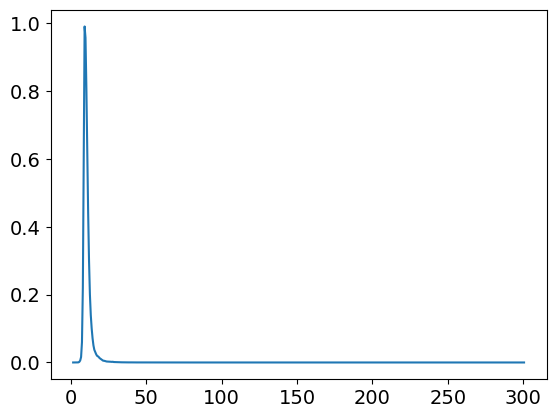

In [28]:
az.plot_kde(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False), "AvNLL"]));

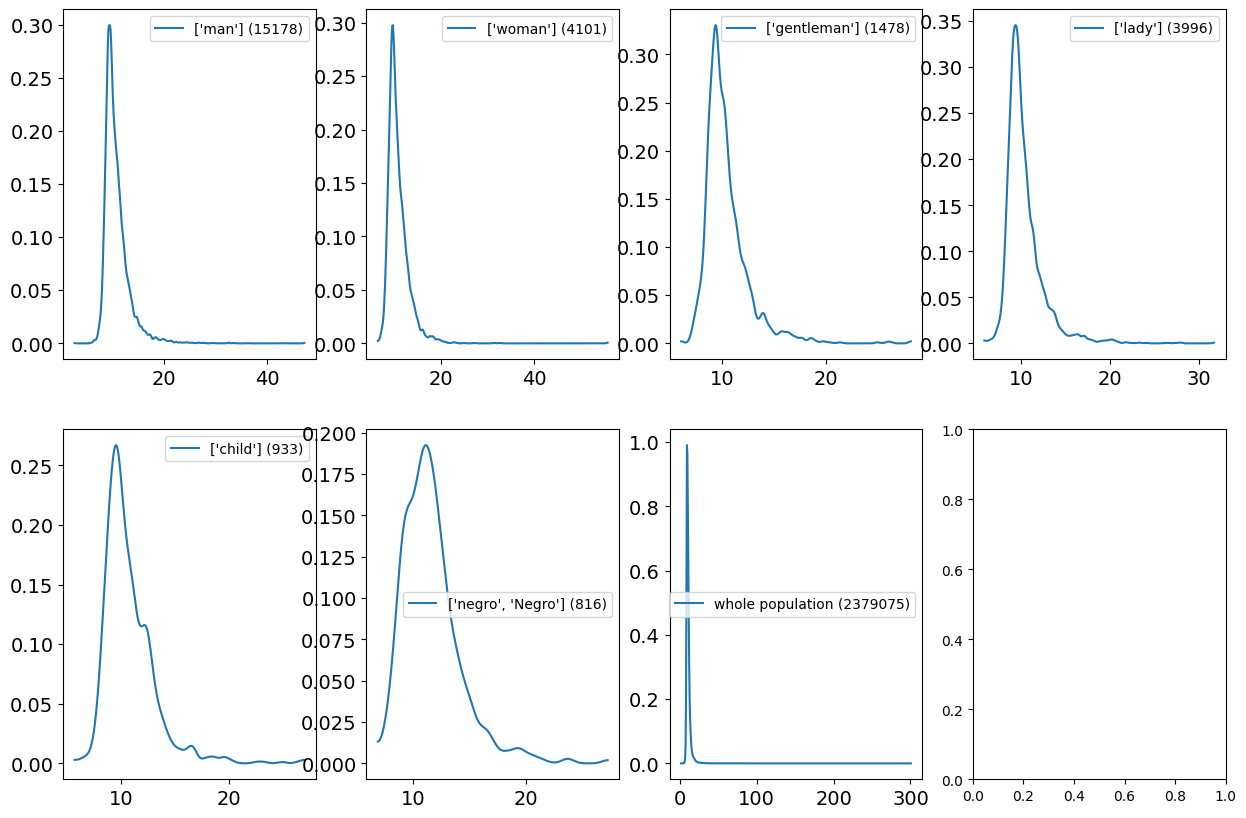

In [29]:
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"], None]):
    row = i // 4
    col = i - (row)*4
    if speaker != None:
        mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "speaker"].isin(speaker))
        az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), ax=axs[row, col], label=f"{speaker} ({sum(mask)})");
    else:
        mask = quotes.loc[:, "AvNLL"].isna()==False
        az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), ax=axs[row, col], label=f"whole population ({sum(mask)})");


### what about the 95% hdi wrt., I scores?

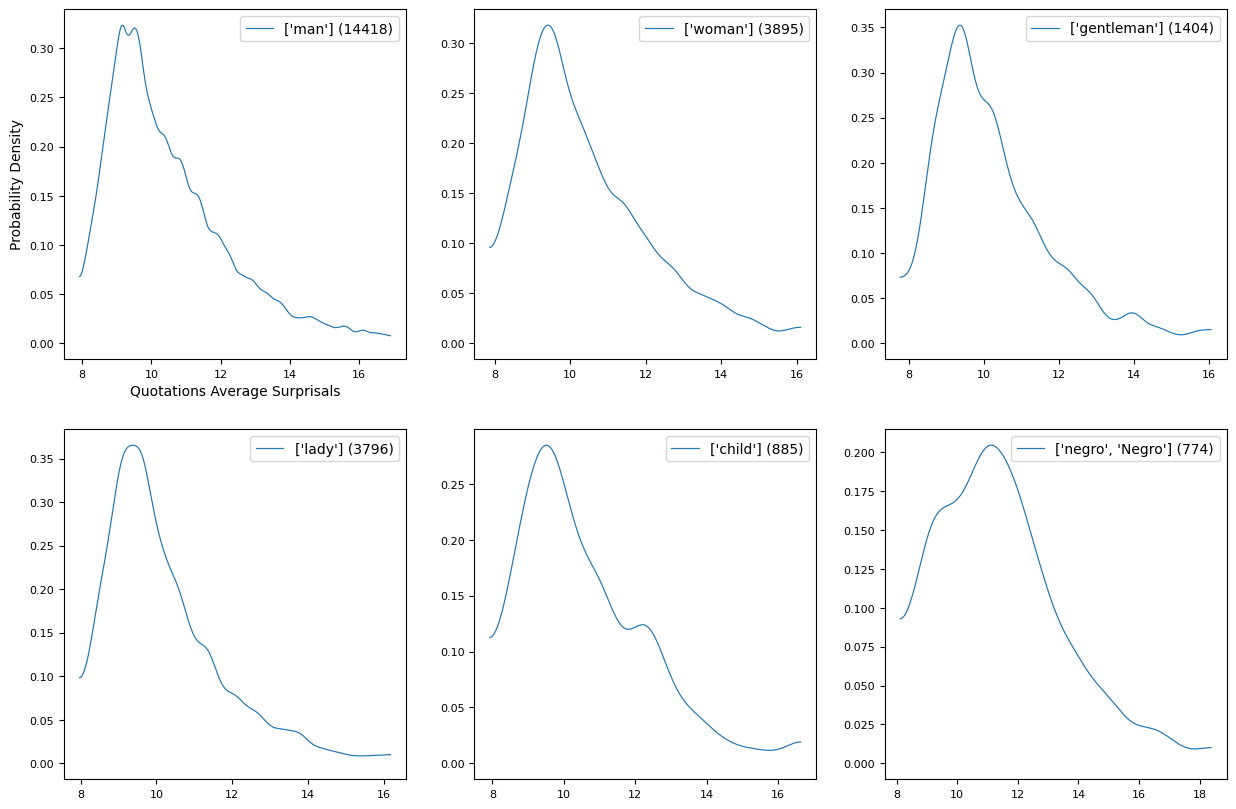

In [30]:
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
# for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"], None]):
for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"]]):

    row = i // y
    col = i - (row)*y
    if speaker != None:
        lb, ub = get_hdi(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "speaker"].isin(speaker)), "AvNLL"]), hdi=0.95)
        mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "AvNLL"] < ub) & (quotes.loc[:, "AvNLL"] > lb) & (quotes.loc[:, "speaker"].isin(speaker))
        az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), ax=axs[row, col], label=f"{speaker} ({sum(mask)})", textsize=8, );
    else: # whole population
        lb, ub = get_hdi(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False), "AvNLL"]), hdi=0.95)
        mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "AvNLL"] < ub) & (quotes.loc[:, "AvNLL"] > lb)
        az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), ax=axs[row, col], label=f"Whole Population ({sum(mask)})", textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel("Quotations Average Surprisals")
        axs[row, col].set_ylabel("Probability Density")



est. average ['man'] 10.493097592397158
est. average ['woman'] 10.456582681532273
est. average ['gentleman'] 10.247047761233555
est. average ['lady'] 10.205827599261225
est. average ['child'] 10.579739639811203
est. average ['negro', 'Negro'] 11.488999713230495


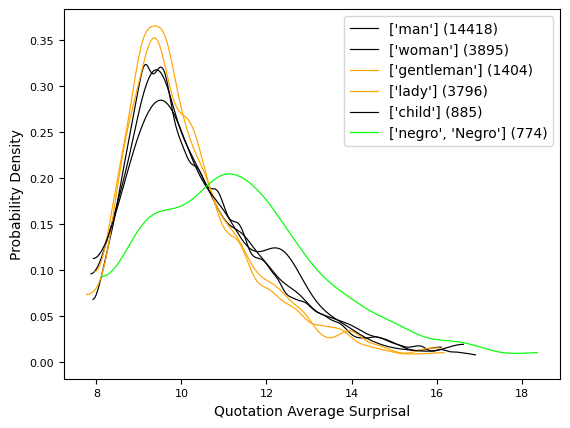

In [31]:
for i, (speaker, color) in enumerate([(["man"], "black"), (["woman"], "black"), (["gentleman"], "orange"), (["lady"], "orange"), (["child"], "black"), (["negro", "Negro"], "lime")]):

    lb, ub = get_hdi(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "speaker"].isin(speaker)), "AvNLL"]), hdi=0.95)
    mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "AvNLL"] < ub) & (quotes.loc[:, "AvNLL"] > lb) & (quotes.loc[:, "speaker"].isin(speaker))

    az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), label=f"{speaker} ({sum(mask)})", textsize=8, plot_kwargs={'color':color});
    plt.xlabel("Quotation Average Surprisal")
    plt.ylabel("Probability Density")

    # est. means
    print("est. average", speaker, quotes.loc[mask, "AvNLL"].mean())

In [33]:
# what do the quotations look like by Surprisal?
for i, speaker in enumerate([["negro", "Negro"]]):
    lb, ub = get_hdi(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "speaker"].isin(speaker)), "AvNLL"]), hdi=0.95)
    mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "AvNLL"] < ub) & (quotes.loc[:, "AvNLL"] > lb) & (quotes.loc[:, "speaker"].isin(speaker))

    for s in [8,10,12, 14]:
        lb, ub = s-0.5, s+0.5
        print(speaker)
        print(lb,ub)
        for i in np.random.choice(list(quotes.loc[(mask) & (quotes.loc[:, "AvNLL"]>lb) & (quotes.loc[:, "AvNLL"]<ub), "i"]), size=5):

            surprisals_by_word = []
            
            c = np.array(chains[i])
            q = quotes.loc[i, 'quote']
            s = q[1:-1]
            words = get_words(s)
            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)
            
            for word, word_indices in zip(words, words_indices):

                surprisal = -np.log(c[word_indices]).sum()
                surprisals_by_word.append((word, surprisal))

            print(surprisals_by_word)
            print(sum([x[1] for x in surprisals_by_word]) / len(surprisals_by_word))
            print(quotes.loc[i,"AvNLL"])

['negro', 'Negro']
7.5 8.5
[('Pomp', 12.745163377911325), (',', 8.908733680239104), ('my', 8.15487741706939), ('noble', 5.593150393431662), ('fellow', 5.8544982882134375), ('!', 7.8913391301704685)]
8.191293714505896
8.191293714505896
[('FIGHT', 16.985638510026394), (',', 8.962578825330812), ('sar', 6.407307565240219), (';', 9.64040859401201), ('gib', 8.812395329353894), ('dem', 5.034492259117673), ('de', 6.710499551343321), ('chance', 9.172713604895229), (',', 8.715849491588925), ('and', 6.814208233488087), ('den', 5.831951792669897), ('see', 5.717314254535503), ('.', 10.186636565387598)]
8.383999582845352
8.383999582845352
[('Oh', 9.549871054655648), ('!', 7.315758530692469)]
8.432814792674058
8.432814792674058
[('Fight', 9.943859488890746), (',', 9.123350096495201), ('sar', 7.1286821471445965), ('!', 6.315767180190526)]
8.127914728180267
8.127914728180267
[('I', 5.929203704151961), ('am', 8.102990544512906), ('dying', 9.271569865863027), (',', 9.365338636542047), ('colonel', 7.95522

## RQ1

14418 774
man 0.9959021208333372
3895 774
woman 1.0324170316982215
1404 774
gentleman 1.2419519519969402
3796 774
lady 1.28317211396927
885 774
child 0.9092600734192917


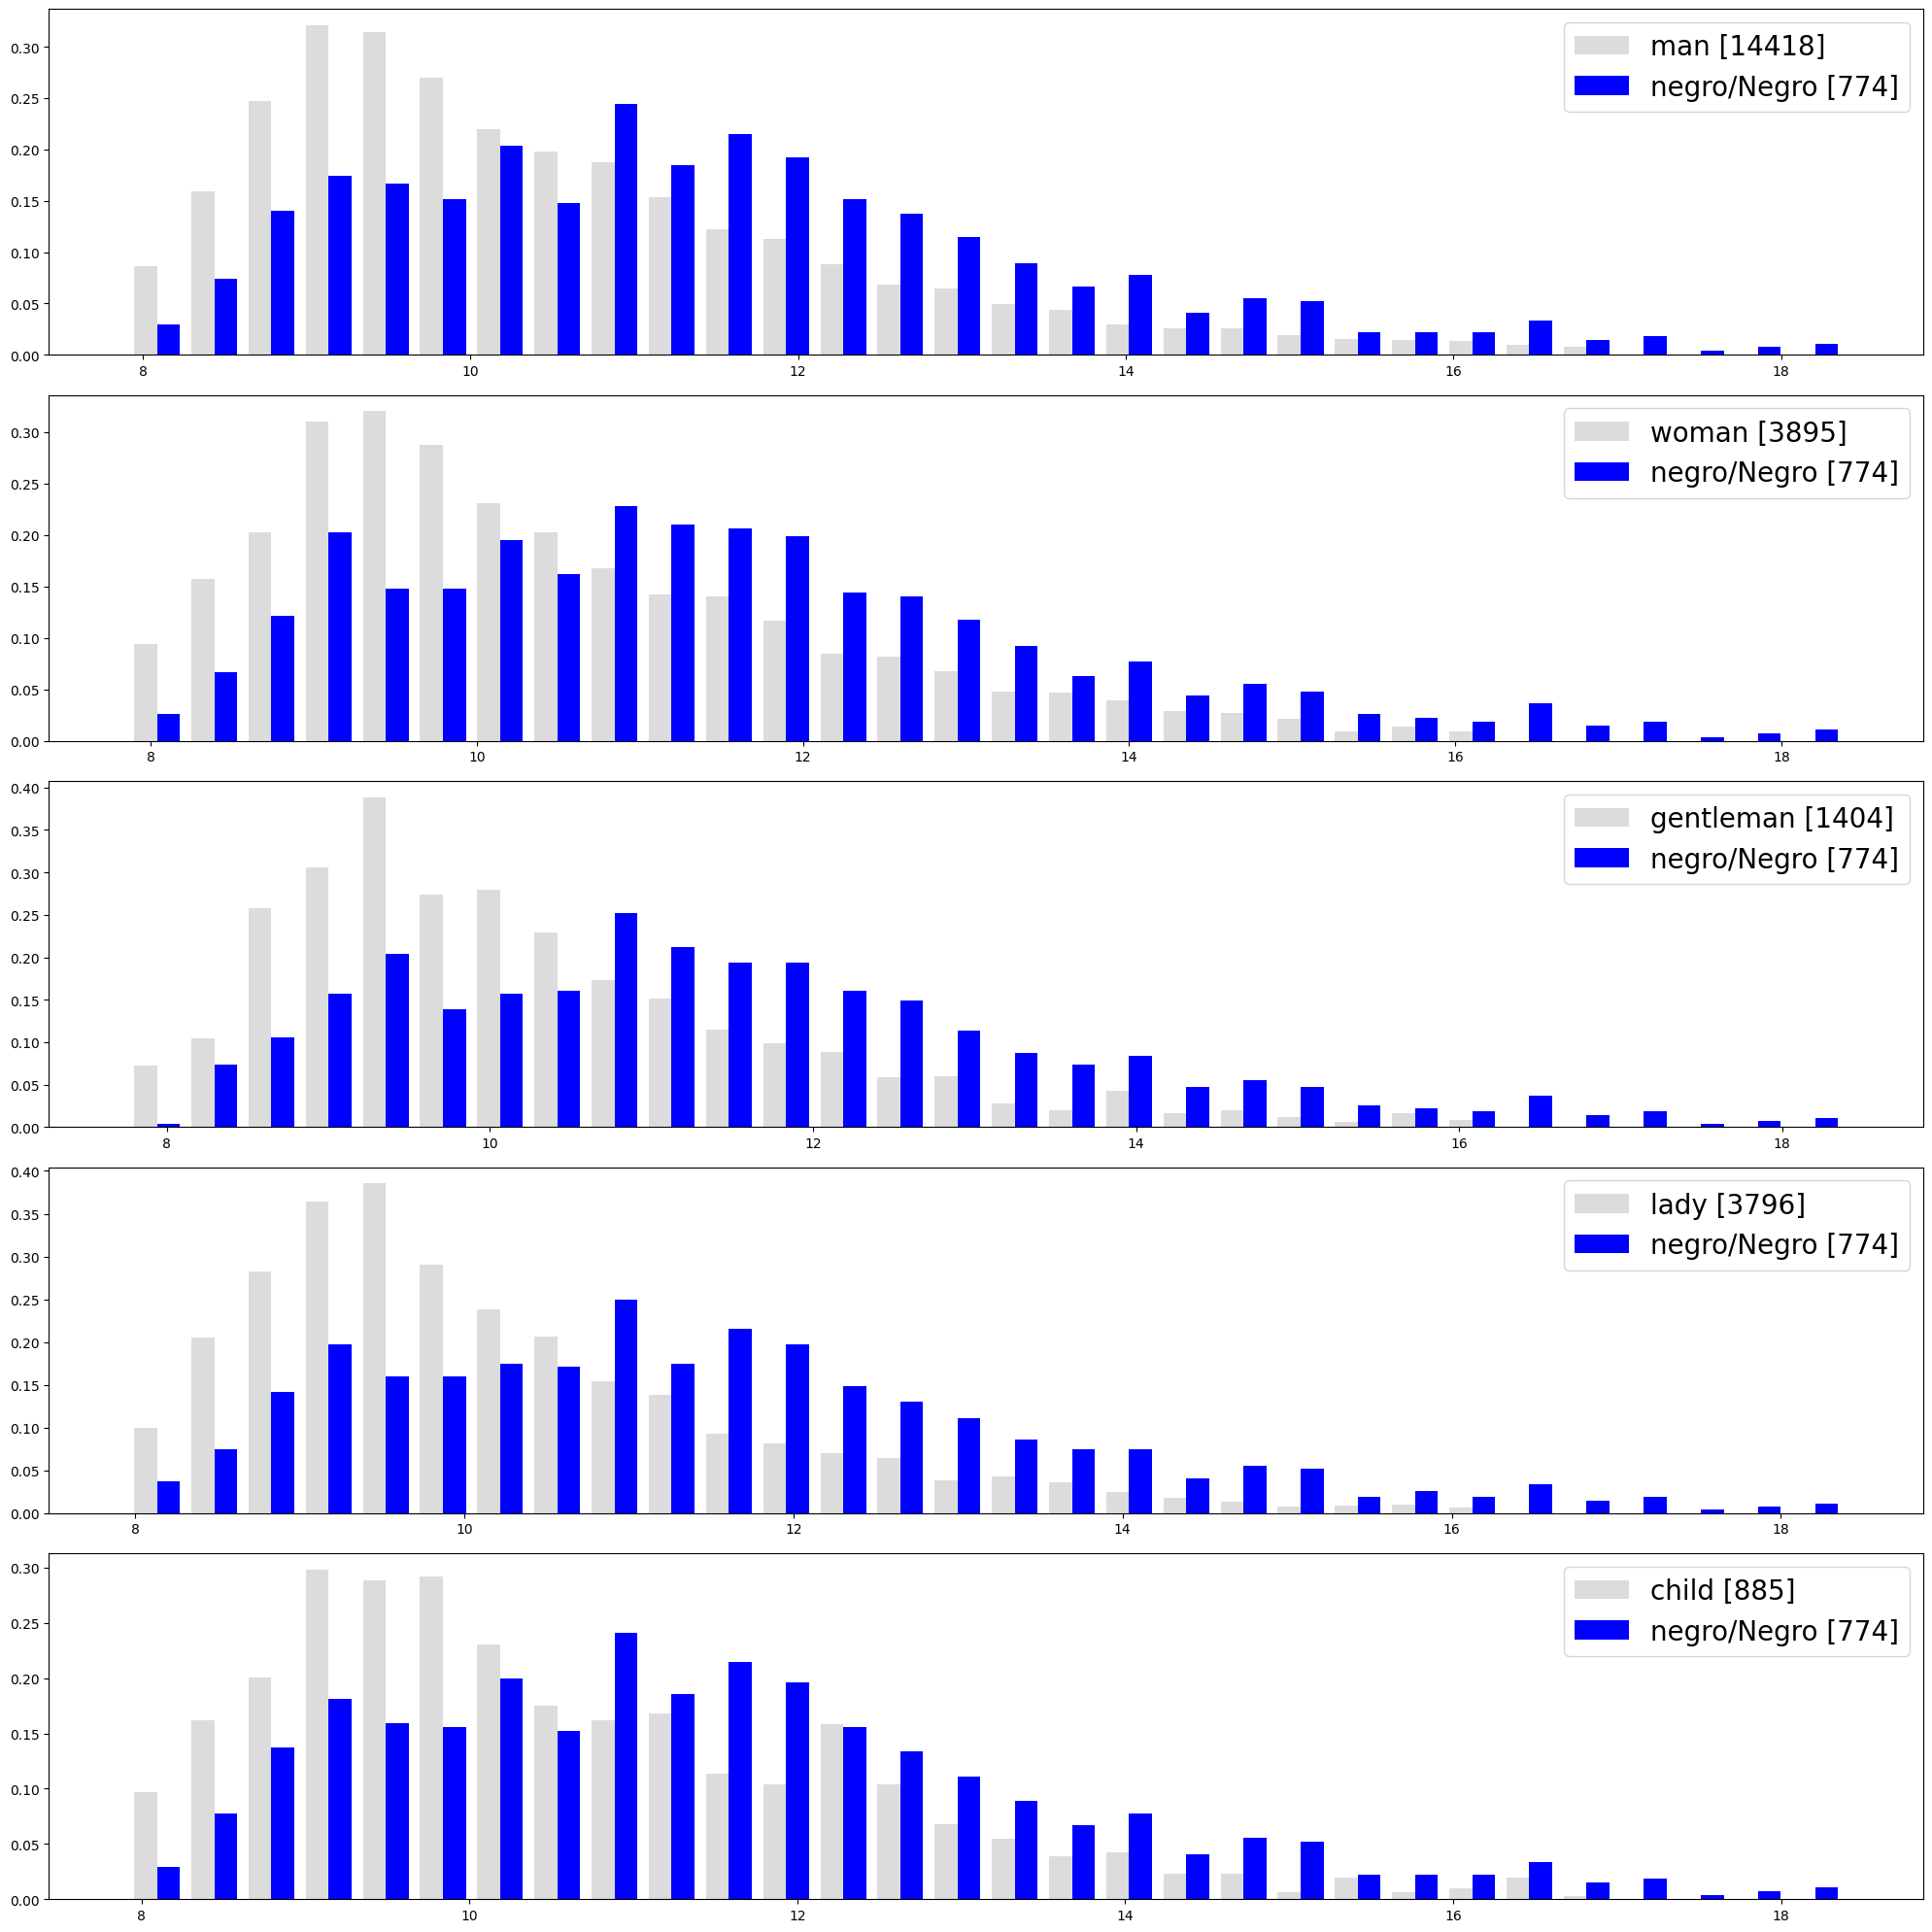

In [34]:
refs = ['man', 'woman', 'gentleman', 'lady', 'child']
metric = 'AvNLL'
fig, axs = plt.subplots(len(refs), figsize=[20,20])

for i, ref in enumerate(refs):

    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin([ref])==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(r_, hdi=0.95)
    r = quotes.loc[(quotes.loc[:,'speaker'].isin([ref])==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
    
    c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(['Negro', 'negro'])==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(c_, hdi=0.95)
    c = quotes.loc[(quotes.loc[:,'speaker'].isin(['Negro', 'negro'])==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]

    print(len(r), len(c))

    # https://matplotlib.org/stable/gallery/color/named_colors.html
    axs[i].hist([r, c], density=True, bins=30, label = [f"{ref} [{len(r)}]", f'negro/Negro [{len(c)}]'], color=['gainsboro', 'blue']);
    axs[i].legend(fontsize=20)
    
    print(ref, c.mean() - r.mean())
    
plt.tight_layout()
plt.savefig("RQ1_histogram.jpg")
plt.show()


# Bayesian Analysis

In [17]:
def estimator(c,r):
    with pm.Model() as model:
       
        ## contentious term
        mu = pm.Normal('mu', 0, 5)
        nu = pm.Exponential('nu', 1)
        sigma = pm.Exponential('sigma', 1)
        pm.StudentT("c", mu=mu, nu=nu, sigma=sigma, observed=c)
        
        ## reference
        mu_ = pm.Normal('mu_', 0, 5)
        nu_ = pm.Exponential('nu_', 1)
        sigma_ = pm.Exponential('sigma_', 1)
        pm.StudentT("r", mu=mu_, nu=nu_, sigma=sigma_, observed=r)
        
        trace=pm.sample()
        
    return model, trace

# def estimator(c,r):
#     with pm.Model() as model:
       
#         ## contentious term
#         mu = pm.Normal('mu', 0, 5)
#         sigma = pm.Exponential('sigma', 1)
#         alpha = pm.Exponential('alpha', 1)
#         pm.SkewNormal("c", mu=mu, sigma=sigma, alpha=alpha, observed=c)
        
#         ## reference
#         mu_ = pm.Normal('mu_', 0, 5)
#         alpha_ = pm.Exponential('alpha_', 1)
#         sigma_ = pm.Exponential('sigma_', 1)
#         pm.SkewNormal("r", mu=mu_, sigma=sigma_, alpha=alpha_, observed=r)
        
#         trace=pm.sample()
        
#     return model, trace
            

In [727]:
# let's look at the comparative variances of the central 95% ...
for cand in [['man'], ['gentleman'], ['woman'], ['lady'], ['child'], ['Negro', 'negro']]:
    c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(c_, hdi=0.95)
    c = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
    print(cand, c.std())


['man'] 1.7438184333923679
['gentleman'] 1.559809009610031
['woman'] 1.6858473277369483
['lady'] 1.5126825156318326
['child'] 1.7388545774100765
['Negro', 'negro'] 2.041724815179362


In [751]:
X = [['Negro', 'negro'], ['man'], ['woman'], ['gentleman'], ['lady'], ['child']]
for i, cand in enumerate(X[:-1]):
    for ref in X[i+1:]:

        r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(r_, hdi=0.95)
        r = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        
        c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(c_, hdi=0.95)
        c = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        model, trace = estimator(c, r)
        
        # cohen's D estimate
        mu = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        mu_ = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        sigma = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=cha4ins * draws
        sigma_ = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

        print(f"{cand} mean est: {get_hdi(mu, hdi=0.99)}")
        print(f"{ref} mean est: {get_hdi(mu_, hdi=0.99)}")
        # print('Cohen\'s d', ref, cand, get_hdi(cohens_d(mu, mu_, sigma, sigma_), hdi=0.99))
        print('est difference in means', ref, cand, get_hdi(mu - mu_, hdi=0.99))
        print(f'est difference in means as a proportion of ... {cand} mean', ref, cand, get_hdi((mu - mu_) / mu, hdi=0.99))

        # alpha = trace.posterior['alpha'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        # print(cand, get_hdi(alpha, hdi=0.99))
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


['Negro', 'negro'] mean est: (11.145207425715652, 11.533620420576378)
['man'] mean est: (10.207124001537249, 10.289383749515887)
est difference in means ['man'] ['Negro', 'negro'] (0.8924767064786806, 1.2877233463816373)
est difference in means as a proportion of ... ['Negro', 'negro'] mean ['man'] ['Negro', 'negro'] (0.08007313253107587, 0.11184260670868354)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


['Negro', 'negro'] mean est: (11.155659704623565, 11.5225175253902)
['woman'] mean est: (10.219962944240004, 10.380036130609675)
est difference in means ['woman'] ['Negro', 'negro'] (0.8370478284107437, 1.2488768578570058)
est difference in means as a proportion of ... ['Negro', 'negro'] mean ['woman'] ['Negro', 'negro'] (0.07511048727175117, 0.10845011772684887)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


['Negro', 'negro'] mean est: (11.149442110381674, 11.535001692711557)
['gentleman'] mean est: (9.892005393249796, 10.113292548443267)
est difference in means ['gentleman'] ['Negro', 'negro'] (1.1173395656238563, 1.5549846689107787)
est difference in means as a proportion of ... ['Negro', 'negro'] mean ['gentleman'] ['Negro', 'negro'] (0.09991722634685579, 0.13512975127946106)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


['Negro', 'negro'] mean est: (11.149448330294573, 11.527297642640473)
['lady'] mean est: (9.876786242234363, 10.00815306893216)
est difference in means ['lady'] ['Negro', 'negro'] (1.1952147438217817, 1.590996354031574)
est difference in means as a proportion of ... ['Negro', 'negro'] mean ['lady'] ['Negro', 'negro'] (0.10714034729694254, 0.13824752821231856)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


['Negro', 'negro'] mean est: (11.13891363977846, 11.536520435238629)
['child'] mean est: (10.247140963005457, 10.567049605985591)
est difference in means ['child'] ['Negro', 'negro'] (0.6755273557596964, 1.1885388028921655)
est difference in means as a proportion of ... ['Negro', 'negro'] mean ['child'] ['Negro', 'negro'] (0.06046047046760653, 0.10391861932823936)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


['man'] mean est: (10.20574086734798, 10.288138263616718)
['woman'] mean est: (10.213775503518875, 10.376949901354186)
est difference in means ['woman'] ['man'] (-0.13916265538874134, 0.04105523468850152)
est difference in means as a proportion of ... ['man'] mean ['woman'] ['man'] (-0.01360454193979968, 0.0040045820206399425)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


['man'] mean est: (10.20849106828361, 10.287725433514419)
['gentleman'] mean est: (9.890386177717197, 10.120532807970154)
est difference in means ['gentleman'] ['man'] (0.12770427427366082, 0.36494079266246604)
est difference in means as a proportion of ... ['man'] mean ['gentleman'] ['man'] (0.01249086451958166, 0.03562615902090765)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


['man'] mean est: (10.209053964887062, 10.288340705304249)
['lady'] mean est: (9.876567513346984, 10.008237561342508)
est difference in means ['lady'] ['man'] (0.23159700608804118, 0.38609406556396086)
est difference in means as a proportion of ... ['man'] mean ['lady'] ['man'] (0.022662466268963937, 0.037606466086931356)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


['man'] mean est: (10.207868330438393, 10.287557964067096)
['child'] mean est: (10.249938450182453, 10.55701437768796)
est difference in means ['child'] ['man'] (-0.3124120930929642, 0.005655649582142479)
est difference in means as a proportion of ... ['man'] mean ['child'] ['man'] (-0.030490074830677883, 0.0005518880674501909)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


['woman'] mean est: (10.214718689005823, 10.374826526623426)
['gentleman'] mean est: (9.891919150908445, 10.114076620031518)
est difference in means ['gentleman'] ['woman'] (0.16471588163932036, 0.43074625933555566)
est difference in means as a proportion of ... ['woman'] mean ['gentleman'] ['woman'] (0.01603401088959873, 0.041619538172851085)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


['woman'] mean est: (10.213653438652155, 10.373567501799354)
['lady'] mean est: (9.87322961962388, 10.008971547144524)
est difference in means ['lady'] ['woman'] (0.2491877926814817, 0.4576027570527828)
est difference in means as a proportion of ... ['woman'] mean ['lady'] ['woman'] (0.024392682181508543, 0.04413873119749567)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


['woman'] mean est: (10.217715873312065, 10.37680326357274)
['child'] mean est: (10.246051881985824, 10.561452795682873)
est difference in means ['child'] ['woman'] (-0.2788274498515965, 0.06582748672542252)
est difference in means as a proportion of ... ['woman'] mean ['child'] ['woman'] (-0.027178317438007804, 0.006357941537713235)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


['gentleman'] mean est: (9.889086480009285, 10.110185797681936)
['lady'] mean est: (9.876500598282844, 10.006382799665001)
est difference in means ['lady'] ['gentleman'] (-0.06489039602493617, 0.1871006070901648)
est difference in means as a proportion of ... ['gentleman'] mean ['lady'] ['gentleman'] (-0.006548480377255518, 0.018568293466056672)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


['gentleman'] mean est: (9.897657400723396, 10.111157381792202)
['child'] mean est: (10.245317473312797, 10.569017493247333)
est difference in means ['child'] ['gentleman'] (-0.5989571826868907, -0.21268463776650232)
est difference in means as a proportion of ... ['gentleman'] mean ['child'] ['gentleman'] (-0.06020213557785577, -0.021119711020566388)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


['lady'] mean est: (9.878839834797216, 10.007960426259691)
['child'] mean est: (10.254309601625758, 10.571610463204621)
est difference in means ['child'] ['lady'] (-0.6324380423033931, -0.3047806273093671)
est difference in means as a proportion of ... ['lady'] mean ['child'] ['lady'] (-0.06378096988686721, -0.030587589705871818)


### hmmm. by how much do the the pooled standard variations differ?

In [222]:
for ref in [['man'], ['gentleman'], ['woman'], ['lady'], ['child'], ['negro', 'Negro']]:
# for r in [['negro', 'Negro']]:

    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(r_, hdi=0.95)
    r = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]

    for cand in [['man'], ['gentleman'], ['woman'], ['lady'], ['child']]:
        
        c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(c_, hdi=0.95)
        c = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        
        print(ref, cand, np.sqrt((r.std()**2 + c.std()**2)/2))

['man'] ['man'] 1.7719258361200607
['man'] ['gentleman'] 1.7146113110469126
['man'] ['woman'] 1.7395905541170773
['man'] ['lady'] 1.7085040389271027
['man'] ['child'] 1.71898149573758
['gentleman'] ['man'] 1.7146113110469126
['gentleman'] ['gentleman'] 1.6553134830690674
['gentleman'] ['woman'] 1.6811740169398275
['gentleman'] ['lady'] 1.6489866070682497
['gentleman'] ['child'] 1.659839800085672
['woman'] ['man'] 1.7395905541170773
['woman'] ['gentleman'] 1.6811740169398275
['woman'] ['woman'] 1.7066427345044841
['woman'] ['lady'] 1.6749448284328072
['woman'] ['child'] 1.685630893746253
['lady'] ['man'] 1.7085040389271027
['lady'] ['gentleman'] 1.6489866070682497
['lady'] ['woman'] 1.6749448284328072
['lady'] ['lady'] 1.6426353622611043
['lady'] ['child'] 1.6535302431490797
['child'] ['man'] 1.71898149573758
['child'] ['gentleman'] 1.659839800085672
['child'] ['woman'] 1.685630893746253
['child'] ['lady'] 1.6535302431490797
['child'] ['child'] 1.6643538075381206
['negro', 'Negro'] ['ma

In [215]:
# n-word vs control only
100*(1.82 - 1.75)/1.75

4.0000000000000036

In [217]:
# all RQ1 pooled stdev
100*(1.82 - 1.64)/1.75

10.285714285714294

### glass's delta

In [224]:
for cand in [['man'], ['gentleman'], ['woman'], ['lady'], ['child']]:
    for ref in [['Negro', 'negro']]:

        r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(r_, hdi=0.95)
        r = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        
        c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(c_, hdi=0.95)
        c = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        model, trace = estimator(c, r)
        
        # cohen's D estimate
        mu = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        mu_ = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        sigma = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        sigma_ = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        print("Glass's d", ref, cand, get_hdi(glass_delta(mu_, mu, sigma_), hdi=0.99))
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Glass's d ['Negro', 'negro'] ['man'] (-0.5676510081847974, -0.34525550547661393)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Glass's d ['Negro', 'negro'] ['gentleman'] (-0.663220113515467, -0.40199732154427736)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Glass's d ['Negro', 'negro'] ['woman'] (-0.5449077190993171, -0.3113233524224895)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Glass's d ['Negro', 'negro'] ['lady'] (-0.597454073398002, -0.3647986517442432)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Glass's d ['Negro', 'negro'] ['child'] (-0.573395998131116, -0.30017288276183446)


## RQ2 

### Assemble df, Q

In [18]:
# load the quotes
with open("../LOC/tuples_news.json", "r") as f:
    tuples_news = json.load(f)

In [19]:
# load the chains
with open("../LOC/chains_1.6B_news.json", "r") as f:
    chains_news = json.load(f)

In [626]:
quotes_news = [q for url, (q,m,s) in tuples_news]
display(quotes_news[:5])


["Hit only cost me a string er fish ter git married, jedge, but, please God, I'd give a whale ter git rid er her.",
 'I hopes dis teaches me a lesson.',
 "There's a dog under them steps, an' he's shore mad.",
 "Gimme that gun quick. I'll kill him,",
 "I came for Mr. Ivans's close."]

In [612]:
# load the LOC quotes chains
display(len(chains_news))

1524

In [613]:
get_words("how's it going?")

["how's", 'it', 'going', '?']

In [627]:
# add N to quotes
word_counts = []
for quote in quotes_news:
    N = len(get_words(quote))
    word_counts.append(N)

In [628]:
# add NLL to quotes
AvNLL = []
for i, n in tqdm(enumerate(word_counts)):
    AvNLL.append(-np.log(chains_news[i]).sum()/n)

1524it [00:00, 89106.16it/s]


In [629]:
Q_news: pd.DataFrame = pd.DataFrame({"quote":quotes_news, "N":word_counts, "AvNLL":AvNLL})

In [630]:
Q_news['i'] = list(range(len(Q_news)))

### let's look at examples ...

In [631]:
display(Q_news.loc[2,"quote"])
display(Q_news.loc[2,"N"])

"There's a dog under them steps, an' he's shore mad."

12

### let's look at the spead

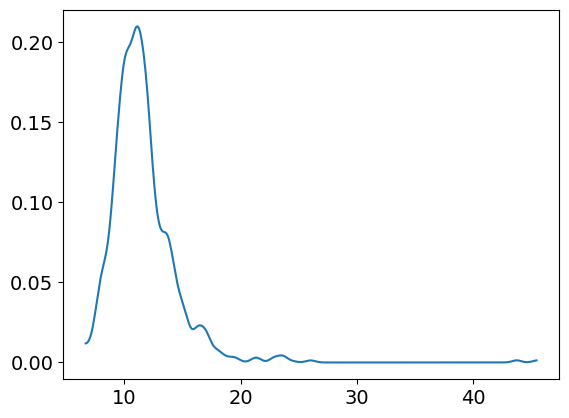

In [632]:
az.plot_kde(np.array(Q_news.loc[:, "AvNLL"]));

### let's look at the spread of 95%

1446

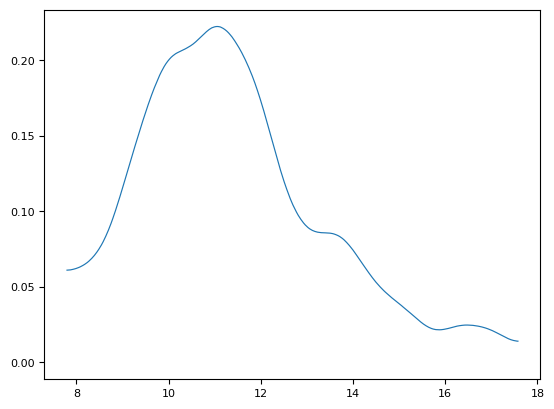

In [752]:
lb, ub = get_hdi(np.array(Q_news.loc[:, "AvNLL"]), hdi=0.95)
mask = ((Q_news.loc[:, "AvNLL"] < ub) & (Q_news.loc[:, "AvNLL"] > lb))
az.plot_kde(np.array(Q_news.loc[mask, "AvNLL"]), textsize=8, );
sum(mask)

In [757]:
### fit estimate the central tendency ... 
metric = "AvNLL"

lb, ub = get_hdi(np.array(Q_news.loc[:, "AvNLL"]), hdi=0.95)
mask = ((Q_news.loc[:, "AvNLL"] < ub) & (Q_news.loc[:, "AvNLL"] > lb))
news = Q_news.loc[mask, metric]

lit_ = quotes.loc[(quotes.loc[:,'speaker'].isin(['negro', 'Negro'])==True) & (quotes.loc[:,metric].isna()==False), metric]
lb, ub = get_hdi(lit_, hdi=0.95)
lit = quotes.loc[(quotes.loc[:,'speaker'].isin(['negro', 'Negro'])==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]

model, trace = estimator(lit, news)

# cohen's D estimate
mu_lit = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
sigma_lit = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
mu_news = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
sigma_news = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
get_hdi((mu_news - mu_lit) / mu_lit, hdi=0.99)
# get_hdi(glass_delta(mu_lit, mu_news, sigma_lit), 0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


(-0.02645469056697198, 0.01573394497527655)

Sampling: [c, r]


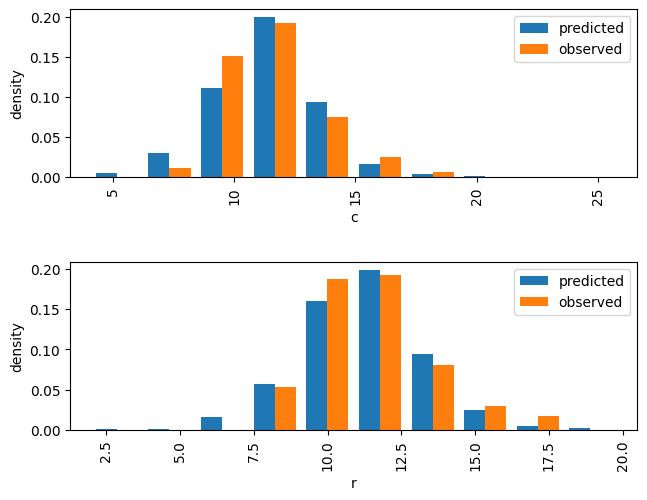

In [754]:
plot_posterior_predictive_overlay(model, trace);

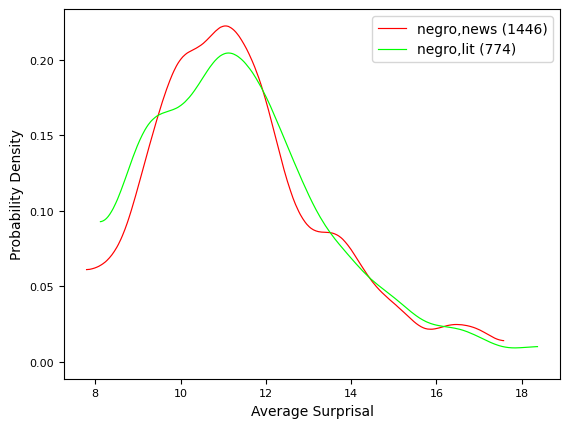

In [794]:
# plot

lb, ub = get_hdi(np.array(Q_news.loc[:, "AvNLL"]), hdi=0.95)
mask = ((Q_news.loc[:, "AvNLL"] < ub) & (Q_news.loc[:, "AvNLL"] > lb))
news = list(Q_news.loc[mask, metric])
az.plot_kde(np.array(news), label=f"negro,news ({len(news)})", textsize=8, plot_kwargs={'color':"red"})


lit_ = quotes.loc[(quotes.loc[:,'speaker'].isin(['negro', 'Negro'])==True) & (quotes.loc[:,metric].isna()==False), metric]
lb, ub = get_hdi(lit_, hdi=0.95)
lit = list(quotes.loc[(quotes.loc[:,'speaker'].isin(['negro', 'Negro'])==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric])
az.plot_kde(np.array(lit), label=f"negro,lit ({len(lit)})", textsize=8, plot_kwargs={'color':"lime"})

plt.ylabel("Probability Density")
plt.xlabel("Average Surprisal")
plt.savefig("RQ2_overlaid")
plt.show()


In [755]:
display(lit.mean())
display(lit.std())

11.488999713230495

2.041724815179362

In [756]:
display(news.mean())
display(news.std())

11.410466500729017

1.9872700280215068

## RQ3: How do the surprisal contributions look by word ?


### get the surprisals by word (lit)

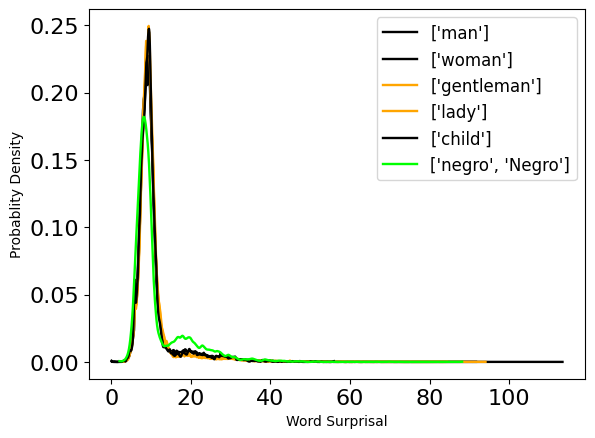

In [801]:
# for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"], None]):
metric = "AvNLL"
# plt.figure(figsize=(7.5, 7.5))
# plt.minorticks_on()
# plt.grid(which='both', linestyle='--', linewidth=0.5)
for j, (speakers, color) in enumerate([(["man"], "black"), (["woman"], "black"), (["gentleman"], "orange"), (["lady"], "orange"), (["child"], "black"), (["negro", "Negro"], "lime")]):
    
    # get the quotes 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), 'i']
    
    surprisals = []
    for i in i_of_interest:
        try:
            c = np.array(chains[i])
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            words = get_words(s)
            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)
        
            for word, word_indices in zip(words, words_indices):
                surprisals.append([word, -np.log(c[word_indices]).sum()])
        except:
            pass
            
    surprisals = sorted(surprisals, key = lambda x: x[1], reverse=True)
    az.plot_kde(np.array([x[1] for x in surprisals]), label=f"{speakers}", textsize=16, plot_kwargs={'color':color});
plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
plt.ylabel("Probablity Density", )
plt.xlabel("Word Surprisal")
plt.savefig("RQ1_word_level_overlay")



### Get surprisals by word (negro,lit vs negro,news)

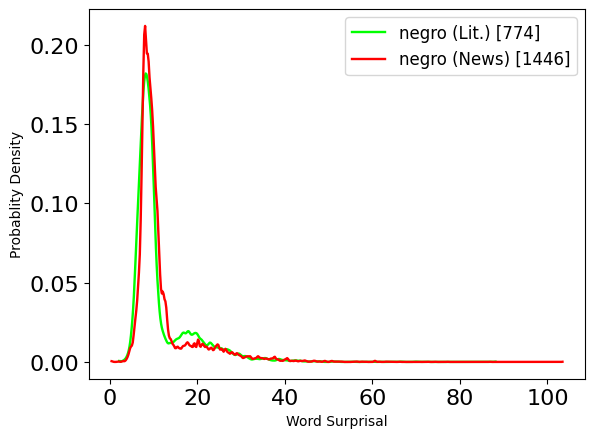

In [804]:
# for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"], None]):
metric = "AvNLL"
# plt.figure(figsize=(7.5, 7.5))
# plt.minorticks_on()
# plt.grid(which='both', linestyle='--', linewidth=0.5)

# ------
# negro, lit 
# ------

speakers, color = (["negro", "Negro"], "lime")
    
# get the quotes 'i' of interest
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False), metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), 'i']

surprisals = []
for i in i_of_interest:
    try:
        c = np.array(chains[i])
        q = quotes.loc[i, 'quote']
        s  = q[1:-1]
        words = get_words(s)
        tokens = np.array(tokenizer.tokenize(s))
        words_indices, N = get_words_indices(words, tokens)
    
        for word, word_indices in zip(words, words_indices):
            surprisals.append([word, -np.log(c[word_indices]).sum()])
    except:
        pass
        
surprisals = sorted(surprisals, key = lambda x: x[1], reverse=True)
az.plot_kde(np.array([x[1] for x in surprisals]), label=f"negro (Lit.) [{len(i_of_interest)}]", textsize=16, plot_kwargs={'color':color});

# ------
# negro, news
# ------

# get 'i' of interest
lb, ub = get_hdi(np.array(Q_news.loc[:, "AvNLL"]), hdi=0.95)
mask = ((Q_news.loc[:, "AvNLL"] < ub) & (Q_news.loc[:, "AvNLL"] > lb))
i_of_interest = Q_news.loc[mask, 'i']

color = 'red'

# get surprisals over words
surprisals_ = []
for i in i_of_interest:
    c = np.array(chains_news[i])
    q = Q_news.loc[i, 'quote']
    s  = q
    words = get_words(s)
    tokens = np.array(tokenizer.tokenize(s))
    try:
        words_indices, N = get_words_indices(words, tokens)
        for word, word_indices in zip(words, words_indices):
            surprisals_.append([word, -np.log(c[word_indices]).sum()])
    except:
        pass
        
surprisals_ = sorted(surprisals_, key = lambda x: x[1], reverse=True)
az.plot_kde(np.array([x[1] for x in surprisals_]), label=f"negro (News) [{len(i_of_interest)}]", textsize=16, plot_kwargs={'color':color});


plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
plt.ylabel("Probablity Density", )
plt.xlabel("Word Surprisal")
plt.savefig("RQ2_word_level_overlay")

Let's take a look at the n-word, lit quoations split into quotaiton Surprisal Bands ... do we observe ...

In [875]:
def values_to_probabilty_density(d:list, bins = 100):
    """ Return (bin_centres: np.ndarry, bin_probability: np.ndarray) tuple for a list of values, d.
    """

    # establish bin width, bin centres, and boundaries
    bin_width = (max(d) - min(d)) / (bins - 1)
    centres = np.array([min(d) + i*bin_width for i in range(bins)])
    lb = centres - bin_width/2
    ub = centres + bin_width/2

    # get counts in each bin
    counts = np.array([0]*len(centres))
    for value in d:
        counts += ((value >= lb) & (value < ub))

    # convert to density
    density = counts / counts.sum()

    return centres, density
        
# test
get_density([1,1,1.1,2, 2,3,4, 5,5,5], 5)

(array([1., 2., 3., 4., 5.]), array([0.3, 0.2, 0.1, 0.1, 0.3]))

198
309
175
65
22


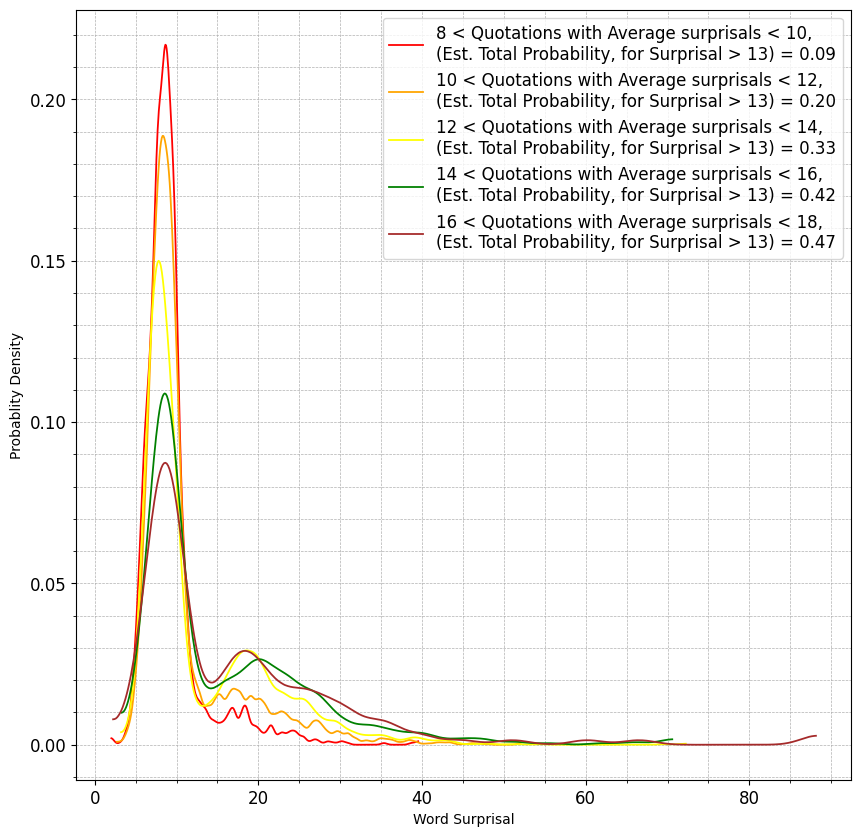

In [904]:
# fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plt.figure(figsize=(10, 10))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)

colours = ['red', 'orange', 'yellow', 'green', 'brown', 'indigo', 'violet']

metric = "AvNLL"
for j, (speakers, color) in enumerate([(["negro", "Negro"], "lime")]):
    
    # get the quotes 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(r_, hdi=0.95)

    # consider bands of Quotation Average Surprisals ... 
for k, band_lb in enumerate(range(8,18,2)):
        band_ub = band_lb+2
        i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] >= band_lb) & (quotes.loc[:,metric] < ub)& (quotes.loc[:,metric] < band_ub), 'i']
        print(len(i_of_interest))
        
        surprisals = []
        for i in i_of_interest:
            try:
                c = np.array(chains[i])
                q = quotes.loc[i, 'quote']
                s  = q[1:-1]
                words = get_words(s)
                tokens = np.array(tokenizer.tokenize(s))
                words_indices, N = get_words_indices(words, tokens)
            
                for word, word_indices in zip(words, words_indices):
                    surprisals.append([word, -np.log(c[word_indices]).sum()])
            except:
                pass
                
        surprisals = sorted(surprisals, key = lambda x: x[1], reverse=True)

        # estimate the total probability between 13 and 30 ... 
        C, P = get_density([x[1] for x in surprisals], 100)
        area = sum([p for c,p in zip(C,P) if c>13])


        # # plot
        # row = k // 3
        # col = k - (row)*3
        # az.plot_kde(np.array([x[1] for x in surprisals]), label=f"{speakers}, \n{(band_lb, band_ub)},\n{area:.2f}", textsize=16, ax=axs[row, col]);

        az.plot_kde(np.array([x[1] for x in surprisals]), label=f"{band_lb} < Quotations with Average surprisals < {band_ub},\n(Est. Total Probability, for Surprisal > 13) = {area:.2f}", textsize=12, plot_kwargs={'color':colours[k]});
    
plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
plt.ylabel("Probablity Density", )
plt.xlabel("Word Surprisal")
plt.savefig("RQ3_word surprisal by quotations surprisal bands")
plt.show()


get words greater than surprisal of 13

In [530]:
metric = "AvNLL"
for speakers in [["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"]]:

    # get the quotes 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    for i in i_of_interest:
        try:
            c = np.array(chains[i])
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            words = get_words(s)
            
            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)
        
            for word, word_indices in zip(words, words_indices):
                surprisal = -np.log(c[word_indices]).sum()
                if surprisal > 15 and surprisal < 25:
                    count += 1
                count_all += 1
        except:
            pass

    print(speakers, count_all/count)

# i.e., 13 to 30 instances occur approx 3.5 as much as gentleman and lady
# i.e., 13 to 30 instances occur approx 3.5 as much as gentleman and lady

['man'] 15.969893120578051
['woman'] 14.833507034914017
['gentleman'] 23.273015873015872
['lady'] 24.573764258555133
['child'] 16.73228346456693
['negro', 'Negro'] 6.8620885357548245


#### News Negro vs Literature Negro

## RQ3: Average Surprisal contribution by *class* of eye - dialect

generally useful functions ...

In [89]:
def gen_indices(reference:list[str], find: list[str])->typing.Generator:
    """ Return the slice lb and ub of the 'reference' array, that share the same elements of the 'find' array
    """
    for i in range(len(reference) - len(find)+1):
        if reference[i:i+len(find)] == find:
            yield (i,i+len(find))

In [300]:
def find_all_indices(word, substring):
    indices = []
    start = 0
    while True:
        start = word.find(substring, start)
        if start == -1:
            break
        indices.append(start)
        start += len(substring)  # Move past the last found index
    return indices

In [306]:
find_all_indices("forthwith", "th")

[3, 7]

mean Average Surprisals of Observed Data

In [84]:
OmAS_lit = {}

for speakers in [["negro", "Negro"], ["man"], ["woman"], ["child"], ["man", "woman", "child"], ["gentleman"], ["lady"], ["gentleman", "lady"]]:
    
    # get 95% HDI wrt. speaker
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    OmAS_lit[",".join(speakers)] = quotes.loc[quotes.loc[:, 'i'].isin(i_of_interest), 'AvNLL'].mean()
display(OmAS_lit)   

OmAS_news = {} 

{'negro,Negro': 11.488999713230495,
 'man': 10.493097592397158,
 'woman': 10.456582681532273,
 'child': 10.579739639811203,
 'man,woman,child': 10.48914714213429,
 'gentleman': 10.247047761233555,
 'lady': 10.205827599261225,
 'gentleman,lady': 10.217235869457516}

### aux verbs (Be, Have, Do) conjugation normalised to third person singular

In [259]:
# let's see what the relative propensity is, if we combine all instances ...
# Note we separate out affirmative and negative purely to avoid double counting

levellings_aux_affirmative = [
    ## present
    "I is", "we is", "We is", "you is", "You is", "they is", "They is", 
    "I has", "we has", "We has", "you has", "You has", "they has", "They has",
    "I does", "we does", "We does", "you does", "You does", "they does", "They does",
    ## past
    "we was", "We was", "they was", "They was",
]

levellings_aux_negative = [
    ## present
    "I isn't", "we isn't", "We isn't", "you isn't", "You isn't", "they isn't", "They isn't", 
    "I hasn't", "we hasn't", "We hasn't", "you hasn't", "You hasn't", "they hasn't", "They hasn't",
    "I doesn't", "we doesn't", "We doesn't", "you doesn't", "You doesn't", "they doesn't", "They doesn't",
    ## past
    "we wasn't", "We wasn't", "they wasn't", "They wasn't",
]

quotes['words'] = quotes['quote'].progress_map(lambda q: get_words(q[1:-1]))
quotes['levellings_aux_affirmative'] = quotes['words'].progress_map(lambda words: [" ".join([word, words[i+1]]) for i, word in enumerate(words[:-1]) if " ".join([word, words[i+1]]) in levellings_aux_affirmative])
quotes['levellings_aux_negative'] = quotes['words'].progress_map(lambda words: [" ".join([word, words[i+1]]) for i, word in enumerate(words[:-1]) if " ".join([word, words[i+1]]) in levellings_aux_negative])
quotes['levellings_aux'] = quotes['levellings_aux_affirmative'] + quotes['levellings_aux_negative']


100%|████████████████████████████████████████████████████████| 2379076/2379076 [00:18<00:00, 129350.50it/s]


In [260]:
quotes['levellings_aux_affirmative_count'] = quotes["levellings_aux_affirmative"].progress_map(lambda x: len(x))
quotes['levellings_aux_negative_count'] = quotes["levellings_aux_negative"].progress_map(lambda x: len(x))
quotes['levellings_aux_count'] = quotes['levellings_aux_affirmative_count'] + quotes['levellings_aux_negative_count'] 

100%|███████████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2051267.25it/s]


In [269]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = df.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (df.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (df.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (df.loc[:,"AvNLL"] < ub), 'i']
    
    print(speakers, 100*sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'levellings_aux_count']) / len(i_of_interest), sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'levellings_aux_count']), len(i_of_interest) )
    

['negro', 'Negro'] 2.1963824289405687 17 774
['man'] 0.29130253849354976 42 14418
['woman'] 0.3337612323491656 13 3895
['gentleman'] 0.07122507122507123 1 1404
['lady'] 0.13171759747102213 5 3796
['child'] 0.3389830508474576 3 885


contribution to difference in mean AvNLL

In [683]:
contribs = {}
S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"],  ["man", "woman", "child"], ["gentleman", "lady",]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']
    
    # collect the sum of surprisals for matching variations
    surprisal = 0  # records total surprisal contribution due to variation under consideraiton
    count_all = 0  # keeps count of all words in quotation set
    for i in i_of_interest:
        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            # convert quote to words           
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            quote_words = get_words(s)
            count_all += len(quote_words)

            tokens = np.array(tokenizer.tokenize(s))

            # relate quote_words to c
            words_indices, N = get_words_indices(quote_words, tokenizer.tokenize(s))


            # get matches wrt., variation type of interest
            if quotes.loc[i, "levellings_aux_count"] > 0:    

                for found in set(quotes.loc[i, "levellings_aux"]):

                    for lb,ub in gen_indices(quote_words, get_words(found)):

                        # get surprisal wrt., double negative
                        for j in range(lb,ub): 
                            word_indices = words_indices[j]
                            # add chain to surprisal
                            surprisal += -np.log(c[word_indices]).sum()  

                        # check! i.e., reassembling tokens according to word_indices yields the targetted string
                        check = []
                        for j in range(lb,ub): 
                            word_indices = words_indices[j]
                            check.append("".join(tokens[word_indices]))
                        print(check, get_words(found))  
        except:
            pass

    contribs[",".join(speakers)] = surprisal / count_all
    
display(contribs)

# get importance:
for s in S[1:]:
    p = 100*(contribs['negro,Negro'] - contribs[','.join(s)]) / (OmAS_lit['negro,Negro'] - OmAS_lit[','.join(s)])
    print(s, p)

['you', "Ġdoesn't"] ['you', "doesn't"]
['Ġyou', 'Ġis'] ['you', 'is']
['Ġis', "Ġh'yar"] ['you', 'is']
['You', 'Ġis'] ['You', 'is']
['ĠI', 'Ġis'] ['I', 'is']
['Ġyou', 'Ġis'] ['you', 'is']
['I', 'Ġis'] ['I', 'is']
['ĠI', 'Ġdoes'] ['I', 'does']
['ĠI', 'Ġhas'] ['I', 'has']
['ĠI', 'Ġis'] ['I', 'is']
['Ġyou', "Ġisn't"] ['you', "isn't"]
['ĠI', "Ġdoesn't"] ['I', "doesn't"]
['ĠI', 'Ġdoes'] ['I', 'does']
['You', 'Ġhas'] ['You', 'has']
['ĠI', 'Ġis'] ['I', 'is']
['Ġyou', 'Ġis'] ['you', 'is']
['ĠI', 'Ġis'] ['I', 'is']
['ĠWe', "Ġwasn't"] ['We', "wasn't"]
['we', 'Ġhas'] ['we', 'has']
['Ġwe', 'Ġdoes'] ['we', 'does']
['Ġis', 'Ġno'] ['you', 'is']
['Ġyou', 'Ġis'] ['you', 'is']
['You', 'Ġdoes'] ['You', 'does']
['ĠI', 'Ġdoes'] ['I', 'does']
['ĠI', 'Ġhas'] ['I', 'has']
['ĠI', 'Ġhas'] ['I', 'has']
['ĠI', 'Ġhas'] ['I', 'has']
['Ġcut', 'Ġout'] ['they', 'was']
['Ġyou', 'Ġis'] ['you', 'is']
['You', 'Ġhas'] ['You', 'has']
['Ġyou', 'Ġhas'] ['you', 'has']
['Ġyou', 'Ġis'] ['you', 'is']
['ĠI', 'Ġis'] ['I', 'is']
['ĠI'

{'negro,Negro': 0.030449565771405736,
 'man': 0.003652937580368525,
 'woman': 0.0039461134146091615,
 'child': 0.007051060468536157,
 'gentleman': 0.0006562837418096938,
 'lady': 0.0013648801232390541,
 'man,woman,child': 0.003840741279661589,
 'gentleman,lady': 0.0011850814517184141}

['man'] 2.6906889372436216
['woman'] 2.5671266109588564
['child'] 2.5733567311362306
['gentleman'] 2.398907782357545
['lady'] 2.2666238871259647
['man', 'woman', 'child'] 2.66127479800058
['gentleman', 'lady'] 2.301094221460765


### Double Modals

e.g., I might could go with you

Consider most common english modals: can, could, may, might, will, would, shall, should, must, ought to, 
Which of these have variation in 1st/2nd/3rd person conjugations?: None

In [286]:
modals = ['can', 'could', 'may', 'might', 'will', 'would', 'shall', 'should', 'must', 'ought to', "can't", "couldn't", "mightn't", "won't", "wouldn't", "shalln't", "shouldn't", "mustn't", "oughtn't to"]
    

#### literature

detection

In [287]:
quotes['double_modals'] = quotes['quote'].progress_map(lambda quote: [" ".join(double) for double in permutations(modals, 2) if " " +  " ".join(double) + " " in quote])
quotes['double_modals_count'] = quotes['double_modals'].progress_map(lambda x: len(x))


100%|███████████████████████████████████████████████████████| 2379076/2379076 [00:00<00:00, 2681096.15it/s]


In [288]:
for q in list(quotes.loc[quotes.loc[:,'double_modals_count'] > 0, 'double_modals']):
    print(q)

['will can']
['can would']
['will must']
['will can']
["shouldn't ought to"]
['will shall']
['will should']
['will shall']
['shall will']
['will would']
['will shall']
['could would']
['will must']
['will would']
['will would']
['will must']
['will must']
['will shall']
["shouldn't ought to"]
['will should']
['would will']
['can might']
['should ought to']
['will could']
['will can']
['will can']
['will would']
['will would']
['will might']
['will must']
['will might']
['will can']
['will can']
['will can']
["will can't"]
['will could']
['will could']
['will would']
['will would']
['can may']
['shall will']
['will would']
['will shall']
['will must']
['will should']
['will would']
['will may']
['will must']
['will can']
['should ought to']
['will would']
['will would']
['will would']
['will may']
['will may']
['will should']
['will might']
['will may']
["couldn't will"]
['will may']
['will might']
['will might']
['will can']
["will wouldn't"]
['will must']
['will would']
['can shall']


rates of occurrence

In [289]:
# literature
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    # get 95% HDI wrt. speaker
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    # rate of double modals
    print(speakers, 100*sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'double_modals_count']) / len(i_of_interest), sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'double_modals_count']), len(i_of_interest) )
    

['negro', 'Negro'] 0.0 0 774
['man'] 0.006935774726036899 1 14418
['woman'] 0.0 0 3895
['gentleman'] 0.0 0 1404
['lady'] 0.0 0 3796
['child'] 0.11299435028248588 1 885


contribution to observed difference in mean Average Surprisal

In [544]:
contribs = {}
S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"],  ["man", "woman", "child"], ["gentleman", "lady",]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']
    
    # collect the sum of surprisals for matching variations
    surprisal = 0  # records total surprisal contribution due to variation under consideraiton
    count_all = 0  # keeps count of all words in quotation set
    
    for i in i_of_interest:
        
        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            # convert quote to words           
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            quote_words = get_words(s)
            count_all += len(quote_words)

            # get the chain indices corresponding to each word
            words_indices, N = get_words_indices(quote_words, tokenizer.tokenize(s))

            if quotes.loc[i, "double_modals_count"] > 0:

                found = set(quotes.loc[i, "double_modals"])  # list of known double modals, get unique variants
                # iterate over double modals
                for x in found:
                    for lb, ub in gen_indices(quote_words, x.split(" ")):
                        for j in range(lb,ub):
                            word_indices = words_indices[j]
                            # add chain to surprisal
                            surprisal += -np.log(c[word_indices]).sum()               
        except:
            pass

    contribs[",".join(speakers)] = surprisal / count_all
    
display(contribs)

# get importance:
for s in S[1:]:
    p = 100*(contribs['negro,Negro'] - contribs[','.join(s)]) / (OmAS_lit['negro,Negro'] - OmAS_lit[','.join(s)])
    print(s, p)

{'negro,Negro': 0.0,
 'man': 6.580863804912675e-05,
 'woman': 0.0,
 'child': 0.001363205884682171,
 'gentleman': 0.0,
 'lady': 0.0,
 'man,woman,child': 0.00010152495712340183,
 'gentleman,lady': 0.0}

['man'] -0.006607942354220544
['woman'] 0.0
['child'] -0.14992474920358115
['gentleman'] 0.0
['lady'] 0.0
['man', 'woman', 'child'] -0.010153992704353722
['gentleman', 'lady'] 0.0


#### news

In [1010]:
# news
Q_news['double_modals'] = Q_news['quote'].progress_map((lambda quote: [" ".join(double) for double in permutations(modals, 2) if " " +  " ".join(double) + " " in quote]))
Q_news['double_modals_count'] = Q_news['double_modals'].progress_map(lambda x: len(x))


# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

# rate
print(100*sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'double_modals_count']) / len(i_of_interest), sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'double_modals_count']), len(i_of_interest) )


100%|██████████████████████████████████████████████████████████████████████████████████████| 1524/1524 [00:00<00:00, 1815942.98it/s]

0.0 0 1446


### Double Negation

E.g., "I ain't never"

In [549]:
p = re.compile(r"\s+\w+(?:n't|aint|haint)\s+(?!said no|say no|saying no)(?:\w+\s+){,2}(?:(?:nuff|noff|noth)in[kg']*|ne[vb]+er|nobody|no)")

# test 1
s = "No, I hain\'t said nuffin,"

# find matches ...
matches = re.findall(p, s)
display(matches)

# find the indices of the matches
for m in matches:
    
    quote_words = get_words(s)    
    match_words = get_words(m)

    for lb, ub in gen_indices(quote_words, match_words):
        print(lb,ub,quote_words[lb:ub])

[" hain't said nuffin"]

3 6 ["hain't", 'said', 'nuffin']


In [550]:
# test 2
s = ['How', 'kin', 'I', 'go', '?', 'I', "ain't", 'got', 'no', 'money', ',', 'and', 'I', "ain't", 'got', 'the', "stren'th", 'to', 'walk', '.', "I'm", "jes'", 'a', 'pore', 'ole', 'man', 'what', "don't", 'mean', 'no', 'harm', 'to', 'nobody', '.', 'Take', 'me', 'along', 'with', 'you-all', '!', "I'm", 'afeared', 'the', "Riders'll", 'git', 'me', "ag'in", '.', 'I', 'come', 'back', 'to', 'see', 'my', 'darter', ',', 'the', 'onliest', 'chile', 'I', 'got', 'in', 'the', "worl'", '.', 'I', "ain't", 'got', 'no', 'other', 'place', 'to', 'go', 'at', '.', 'The', 'Madam', "won't", 'let', 'a', 'pore', 'ole', 'man', 'suffer', '.', 'I', 'wants', 'to', 'see', 'my', 'darter', '.']
o = ["ain't", 'got', 'no']

for lb,ub in gen_indices(s, o):
    print(lb,ub,s[lb:ub])

6 9 ["ain't", 'got', 'no']
66 69 ["ain't", 'got', 'no']


#### n-word,lit vs normative,lit

In [551]:

quotes['double_negatives'] = quotes['quote'].progress_map(lambda quote: re.findall(p, quote))
quotes['double_negatives_count'] = quotes['double_negatives'].progress_map(lambda x: len(x))

100%|███████████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2028327.48it/s]


In [553]:
list(zip(quotes.loc[(quotes.loc[:,'double_negatives_count']>0) & (quotes.loc[:,'speaker'].isin(["negro", "Negro"])), 'double_negatives'], quotes.loc[(quotes.loc[:,'double_negatives_count']>0) & (quotes.loc[:,'speaker'].isin(["negro", "Negro"])), 'quote']))


[([" don't know nuffin"],
  '"Carl\'s forgot his English, and don\'t know nuffin what she wants! he, he, he! Or if she makes him und\'stan\' one ting, den he talks Dutch, and _she_ don\'t und\'stan.\' And so dey\'se habin\' it, fust one, den tudder, while Miss Jinny she hears \'em and comes fur to let us know. But how de ol\' critter eber found you out, dat am one ob de mysteries!"'),
 ([" ain't neber done nuffin"],
  '"scuse me fur int\'ruptin\', but I can\'t help it. Don\' you go, an ax an ole man like me if I tinks dat ole miss went away cos you was comin\' an\' if it\'s my true b\'lief dat she\'ll neber come back while you is h\'yar. Don\' ask me nuffin like dat, Mahs\' Junius. Ise libed in dis place all my bawn days, an\' I ain\'t neber done nuffin to you, Mahs\' Junius, \'cept keepin\' you from breakin\' you neck when you was too little to know better. I neber \'jected to you marryin\' any lady you like bes\', an\' \'tain\'t f\'ar Mahs\' Junius, now Ise ole an\' gittin\' on de ca

rate of variation observed

In [564]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    # get 95\% HDI
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    # 100 count(variation) / count(quotatations)
    print(speakers, 100*sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'double_negatives_count']) / len(i_of_interest), sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'double_negatives_count']), len(i_of_interest) )
    

['negro', 'Negro'] 1.8087855297157622 14 774
['man'] 0.8253571923983909 119 14418
['woman'] 1.1810012836970476 46 3895
['gentleman'] 0.07122507122507123 1 1404
['lady'] 0.2107481559536354 8 3796
['child'] 0.3389830508474576 3 885


Get contribution to mean AvNLL

In [641]:
contribs = {}
S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"],  ["man", "woman", "child"], ["gentleman", "lady",]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']
    
    # collect the sum of surprisals for matching variations
    surprisal = 0  # records total surprisal contribution due to variation under consideraiton
    count_all = 0  # keeps count of all words in quotation set
    
    for i in i_of_interest:
        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            # convert quote to words           
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            quote_words = get_words(s)
            count_all += len(quote_words)
            
            tokens = np.array(tokenizer.tokenize(s))

            # relate quote_words to c
            words_indices, N = get_words_indices(quote_words, tokenizer.tokenize(s))

            if quotes.loc[i, 'double_negatives_count']>0:

                for found in set(quotes.loc[i, 'double_negatives']):

                    for lb,ub in gen_indices(quote_words, get_words(found)):

                        # get surprisal wrt., double negative
                        for j in range(lb,ub): 
                            word_indices = words_indices[j]
                            # add chain to surprisal
                            surprisal += -np.log(c[word_indices]).sum()  

                        # check! i.e., reassembling tokens according to word_indices yields the targetted string
                        check = []
                        for j in range(lb,ub): 
                            word_indices = words_indices[j]
                            check.append("".join(tokens[word_indices])[1:])  # remove 'Ġ'
                        print(check, get_words(found))   
                            
        except:
            pass

    contribs[",".join(speakers)] = surprisal / count_all
    
display(contribs)

# get importance:
for s in S[1:]:
    p = 100*(contribs['negro,Negro'] - contribs[','.join(s)]) / (OmAS_lit['negro,Negro'] - OmAS_lit[','.join(s)])
    print(s, p)

["don't", 'know', 'nuffin'] ["don't", 'know', 'nuffin']
['neber', 'done', 'nuffin', 'to'] ["ain't", 'neber', 'done', 'nuffin']
["ain't", 'never'] ["ain't", 'never']
["don't", 'think', "nothin'"] ["don't", 'think', "nothin'"]
["ain't", 'no'] ["ain't", 'no']
["didn't", 'take', 'you', 'no'] ["didn't", 'take', 'you', 'no']
["don't", 'think', "nothin'"] ["don't", 'think', "nothin'"]
["hain't", 'throwed', 'up', 'no'] ["hain't", 'throwed', 'up', 'no']
["won't", 'make', 'no'] ["won't", 'make', 'no']
['haint', 'nebber'] ['haint', 'nebber']
["don't", 'specks', 'nuffin'] ["don't", 'specks', 'nuffin']
["wudn't", 'ben', 'no'] ["wudn't", 'ben', 'no']
["warn't", 'no'] ["warn't", 'no']
["don't", 'mean', 'no'] ["don't", 'mean', 'no']
["ain't", 'got', 'no'] ["ain't", 'got', 'no']
['got', 'no', 'other'] ["ain't", 'got', 'no']
["didn't", 'show', 'no'] ["didn't", 'show', 'no']
["don't", 'make', 'no'] ["don't", 'make', 'no']
["won't", 'lose', 'no'] ["won't", 'lose', 'no']
["don't", 'want', 'nothing'] ["don'

{'negro,Negro': 0.04793403914057224,
 'man': 0.018597421594395674,
 'woman': 0.030374086365322777,
 'child': 0.010077646381869627,
 'gentleman': 0.0024791110201904634,
 'lady': 0.00419154879113774,
 'man,woman,child': 0.020668412422180562,
 'gentleman,lady': 0.003757108252799661}

['man'] 2.9457330125603787
['woman'] 1.7008584938167008
['child'] 4.16342846951839
['gentleman'] 3.6599586680704186
['lady'] 3.408933990478074
['man', 'woman', 'child'] 2.7269647052563495
['gentleman', 'lady'] 3.473674071179096


#### news

In [292]:
Q_news['double_negatives'] = Q_news['quote'].progress_map(lambda quote: re.findall(p, quote))
Q_news['double_negatives_count'] = Q_news['double_negatives'].progress_map(lambda x: len(x))

100%|██████████████████████████████████████████████████████████████████████████████████████| 1524/1524 [00:00<00:00, 1394441.38it/s]


In [298]:
list(Q_news.loc[Q_news.loc[:,'double_negatives_count']>0, 'double_negatives'])

[[" hadn't never "],
 [" ain't zactly made no "],
 [" ain't doing nothing "],
 [" don't know nothing "],
 [" ain't never "],
 [" ain't got no "],
 [" ain't got no "],
 [" hain't no "],
 [" wasn't no "],
 [" ain't noffin' "],
 [" didn't do no "],
 [" don't needs no "],
 [" don't know nuffin."],
 [" worn't nothin' "],
 [" ain't no "],
 [" ain't got no "],
 [" won't hurt nobody,"],
 [" ain't no "],
 [" ain't done nothin'."],
 [" ain't no "],
 [" can't git nuffin' "],
 [" hain't got no "],
 [" worn't no "],
 [" worn't nothin' "],
 [" don't want nothin' "],
 [" can't do nuffin' "],
 [" ain't no "],
 [" hain't heeerd nothin' "],
 [" hain't got no "],
 [" won't be no "],
 [" worn't nothin' "],
 [" ain't seed nothin',"],
 [" ain't seed nothin' "],
 [" can't tell nothin' "],
 [" ain't got no "],
 [" hain't got no "],
 [" ain't no "],
 [" didn't hab no ", " don't like turkey no "],
 [" worn't no "],
 [" worn't nothin' "],
 [" don't want nothin' "],
 [" ain't no "],
 [" ain't no "],
 [" ain't don

percentage of quotations ....

In [293]:
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

print('news+negro', 100*sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'double_negatives_count']) / len(i_of_interest), sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'double_negatives_count']), len(i_of_interest) )


news+negro 3.2503457814661134 47 1446


In [1019]:
contrib_news = 0

# get the quotation set, 'i' of interest
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

# collect the sum of surprisals for matching variations
surprisal = 0  # records total surprisal contribution due to variation under consideraiton
count_all = 0  # keeps count of all words in quotation set
for i in i_of_interest:
    try:

        # get probability chain corresponding to quote
        c = np.array(chains_news[i])
        
        # convert quote to words           
        q = Q_news.loc[i, 'quote']
        s  = q
        quote_words = get_words(s)
        count_all += len(quote_words)

        # get matches wrt., variation type of interest
        matches = re.findall(p, s)

        # iterate over matches ...
        for m in matches: 
            
            match_words:list[str] = get_words(m)

            # get probability chains wrt., match, m
            for lb_,ub_ in gen_indices(quote_words, match_words):
                # add chain to surprisal
                surprisal += -np.log(c[lb_:ub_]).sum()               
    except:
        print(i)

contrib_news = surprisal / count_all
print(contrib_news)

# get ratios of contribution:
print(contrib_news / contribs['negro,Negro'])


1446
0.05660715083603921
1.9523426120487677


### done VERB

they done ate all of their food


In [35]:
import spacy

In [36]:
nlp = spacy.load("en_core_web_sm")

#### n-word,lit vs normative,lit

rate

In [640]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    print(speakers)

    # get count of "PRON done VERB" and ""
    count = 0
    for q in tqdm(list(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)), "quote"])):
        doc = nlp(q[1:-1])
        q_ = " ".join(['done' if token.text == 'done' else token.pos_ for token in doc])  # converted all words to POS, except for 'done' text

        if "PRON done VERB" in q_ or "PROPN done VERB" in q_:
            # print(q)
            count += 1

    print(speakers, count, len(i_of_interest), 100*count / len(i_of_interest))

['negro', 'Negro']


100%|███████████████████████████████████████████████████████████████████| 774/774 [00:04<00:00, 170.82it/s]


['negro', 'Negro'] 5 774 0.6459948320413437
['man']


  8%|█████▏                                                          | 1166/14418 [00:06<01:13, 179.31it/s]


KeyboardInterrupt: 

contribution to mean Average Surprisal

In [639]:
contribs = {}
S = [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:

    print(speakers)
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    # collect the sum of surprisals for matching variations
    surprisal = 0  # records total surprisal contribution due to variation under consideraiton
    count_all = 0  # keeps count of all words in quotation set
    for i in tqdm(i_of_interest):
        
        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]

            # convert quote to words           
            quote_words = get_words(s)
            count_all += len(quote_words)

            # identify sequential 'done verb'
            matches = []
            prev = None
            for token in nlp(s):
                if prev == 'done' and token.pos_=="VERB":
                    matches.append(["done", token.text])
                prev = token.text

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(quote_words, tokens)

            # get matches wrt., variation type of interest
            for found in matches:

                for lb,ub in gen_indices(get_words(s), found):

                    # get surprisal wrt., target string
                    for j in range(lb,ub): 
                        word_indices = words_indices[j]
                        surprisal += -np.log(c[word_indices]).sum() 

                    # # check! i.e., reassembling tokens according to word_indices yields the targetted string
                    # check = []
                    # for j in range(lb,ub): 
                    #     word_indices = words_indices[j]
                    #     check.append("".join(tokens[word_indices])[1:])  # remove 'Ġ'
                    # print(check, found)

        except:
            print(i)

    contribs[",".join(speakers)] = surprisal / count_all
display(contribs)

# get importance:
for s in S[1:]:
    p = 100*(contribs['negro,Negro'] - contribs[','.join(s)]) / (OmAS_lit['negro,Negro'] - OmAS_lit[','.join(s)])
    print(s, p)

['negro', 'Negro']


100%|███████████████████████████████████████████████████████████████████| 774/774 [00:04<00:00, 168.08it/s]


['man']


100%|███████████████████████████████████████████████████████████████| 14418/14418 [01:22<00:00, 173.86it/s]


['woman']


100%|█████████████████████████████████████████████████████████████████| 3895/3895 [00:22<00:00, 171.88it/s]


['gentleman']


100%|█████████████████████████████████████████████████████████████████| 1404/1404 [00:08<00:00, 164.70it/s]


['lady']


100%|█████████████████████████████████████████████████████████████████| 3796/3796 [00:23<00:00, 162.64it/s]


['child']


100%|███████████████████████████████████████████████████████████████████| 885/885 [00:04<00:00, 193.44it/s]


['man', 'woman', 'child']


100%|███████████████████████████████████████████████████████████████| 19199/19199 [01:50<00:00, 173.86it/s]


['gentleman', 'lady']


100%|█████████████████████████████████████████████████████████████████| 5200/5200 [00:31<00:00, 166.57it/s]


{'negro,Negro': 0.008114287245406485,
 'man': 0.002479131178758582,
 'woman': 0.0012922752982185218,
 'gentleman': 0.0007345845185867981,
 'lady': 0.0,
 'child': 0.005866318835014516,
 'man,woman,child': 0.0023655633127957184,
 'gentleman,lady': 0.00018650700404503038}

['man'] 0.5658343273666889
['woman'] 0.6607806475224884
['gentleman'] 0.5942019508044436
['lady'] 0.6323615637427115
['child'] 0.2472305202997022
['man', 'woman', 'child'] 0.5749571585646925
['gentleman', 'lady'] 0.6233688966846139


In [630]:
[x.pos_ for x in nlp("ain't")]

['VERB', 'PART']

In [593]:
tokens = tokenizer.tokenize("But ain't I done won it?")
words = get_words("But ain't I done won it?")
words_indices = get_words_indices(words, tokens)
words_indices

([[0], [1, 2], [3], [4], [5], [6], [7]], 7)

In [427]:
# # news
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

count = 0
for q in tqdm(list(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)), "quote"])):
    
    doc = nlp(q)
    q_ = " ".join(['done' if token.text == 'done' else token.pos_ for token in doc])

    if "PRON done VERB" in q_ or "PROPN done VERB" in q_:
        print(q)
        count += 1


print("negro+news", count, len(i_of_interest), 100*count / len(i_of_interest))

 31%|████████████████████████████▋                                                              | 455/1446 [00:02<00:05, 187.86it/s]

I reckon we done pitched into a cloudburst


 38%|██████████████████████████████████▊                                                        | 553/1446 [00:03<00:04, 185.50it/s]

I done 'quire about yer kyracktir, and I done find out it are no good.


 48%|███████████████████████████████████████████▊                                               | 696/1446 [00:04<00:04, 176.49it/s]

heah's where I weaken, I'll tell you the trufe. I done serve four years over in Pennsylvania, and I let that there little bird out because I don't want to see nuffin' behind bars.


 51%|██████████████████████████████████████████████▏                                            | 733/1446 [00:04<00:04, 160.53it/s]

Afo' de Lawd, Boss, is hit you dat's cookin' dat chicking? I done smelled hit more'n a miled away, and hab bin huntin' foh de Lawd's sake, jist gib me a leetle, teenty, weenty sup in dis heah tin-cup for my boss. He's an ossifer, an' is layin' in de ossifer's horse-pistol ober dar. Hit'll do him a powerful sight ob good.


 61%|███████████████████████████████████████████████████████▉                                   | 889/1446 [00:05<00:03, 171.97it/s]

Now, see heah. Yo' can go fru th' whole blamed joggarfy, but Massa Sherman he done say that nobody can get pas' me wifout sayin' Cambridge!


 70%|███████████████████████████████████████████████████████████████▎                          | 1017/1446 [00:06<00:02, 196.40it/s]

Now see heah. Yo' can go fru th' whole blamed joggrafy, but Massa Sherman he done say that nobody can get pas' me wifout sayin' Cambridge!
Well, here's what I done come ax yuh,


 76%|████████████████████████████████████████████████████████████████████▏                     | 1095/1446 [00:06<00:01, 186.79it/s]

if I done had chicken for supper would they by able to see it?
Well, here's what I done come to ax yuh,


 84%|███████████████████████████████████████████████████████████████████████████▋              | 1216/1446 [00:07<00:01, 172.54it/s]

Now, seea heah - yo' can go fru th' whole blamed joggrafy; but Massa Sherman he done say that nobody can get pas' me wifout sayin' 'Cambridge!
Yes, but you see Massa Stranger one ob dem Virginny gemmens come 'long here last year, and showed him how to eat greens in his licker; he liked it so well dat he done stuck to it till it killed him.
Miss 'Gusta,  I done named dat calf.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1446/1446 [00:08<00:00, 169.87it/s]

negro+news 12 1446 0.8298755186721992


## pronunciation of the voiceless dental fricative as 'f'

In [292]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [514]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]
    

In [515]:
# get all words with DH
TH = [line for line in lines if " TH" in line]
TH

['AALSETH  AA1 L S EH0 TH',
 'ABENDROTH  AE1 B IH0 N D R AO0 TH',
 'ABERNATHY  AE1 B ER0 N AE2 TH IY0',
 'ABERNETHY  AE1 B ER0 N EH2 TH IY0',
 'ABSINTHE  AE1 B S IH0 N TH',
 'ACCUHEALTH  AE1 K Y UW0 HH EH2 L TH',
 'ACERO(2)  AH0 TH EH1 R OW0',
 'AEROSMITH  EH1 R OW0 S M IH2 TH',
 "AEROSMITH'S  EH1 R OW0 S M IH2 TH S",
 'AESTHENOPIA  AE0 S TH AH0 N AO1 P Y AH0',
 'AESTHETE  EH1 S TH IY0 T',
 "AESTHETE'S  EH1 S TH IY0 T S",
 'AESTHETES  EH1 S TH IY0 T S',
 'AESTHETIC  EH0 S TH EH1 T IH0 K',
 'AESTHETICALLY  EH0 S TH EH1 T IH0 K L IY0',
 'AESTHETICS  EH0 S TH EH1 T IH0 K S',
 'AFORETHOUGHT  AH0 F AO1 R TH AA2 T',
 'AFTERMATH  AE1 F T ER0 M AE2 TH',
 'AFTERMATHS  AE1 F T ER0 M AE2 TH S',
 'AFTERTHOUGHT  AE1 F T ER0 TH AA2 T',
 'AFTERTHOUGHT(1)  AE1 F T ER0 TH AO2 T',
 'AFTERTHOUGHTS  AE1 F T ER0 TH AA2 T S',
 'AFTERTHOUGHTS(1)  AE1 F T ER0 TH AO2 T S',
 'AGATHA  AE1 G AH0 TH AH0',
 'AINSWORTH  EY1 N S W ER0 TH',
 "AINSWORTH'S  EY1 N Z W ER0 TH S",
 'AITHNE  EY1 TH N',
 'ALBERTHAL  AE1 L B 

In [516]:
# Expand TH to include variants of words where ING is replaced with IN'
display([" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in TH if x.split(" ")[0][-3:]=="ING"])
TH += [" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in TH if x.split(" ")[0][-3:]=="ING"]

["ANYTHIN'  EH1 N IY0 TH IH2 NG",
 "AUTHENTICATIN'  AO0 TH EH1 N T AH0 K EY2 T IH0 NG",
 "AUTHORIN'  AO1 TH ER0 IH0 NG",
 "AUTHORIZIN'  AO1 TH ER0 AY2 Z IH0 NG",
 "BIRTHIN'  B ER1 TH IH0 NG",
 "BREATHTAKIN'  B R EH1 TH T EY2 K IH0 NG",
 "COAUTHORIN'  K OW1 AA1 TH ER0 IH0 NG",
 "EARTHLIN'  ER1 TH L IH0 NG",
 "EARTHMOVIN'  ER1 TH M UW2 V IH0 NG",
 "EARTHSHAKIN'  ER1 TH SH EY2 K IH0 NG",
 "EVERYTHIN'  EH1 V R IY0 TH IH2 NG",
 "FORTHCOMIN'  F AO1 R TH K AH1 M IH0 NG",
 "LENGTHENIN'  L EH1 NG TH AH0 N IH0 NG",
 "LIFE-THREATENIN'  L AY1 F TH R EH2 T N IH0 NG",
 "LOATHIN'  L OW1 TH IH0 NG",
 "MOTHBALLIN'  M AO1 TH B AO1 L IH0 NG",
 "NOTHIN'  N AH1 TH IH0 NG",
 "NOTWITHSTANDIN'  N AA2 T W IH0 TH S T AE1 N D IH0 NG",
 "OVERTHROWIN'  OW1 V ER0 TH R OW2 IH0 NG",
 "PLAYTHIN'  P L EY1 TH IH2 NG",
 "REAUTHORIZIN'  R IY0 AO1 TH ER0 AY2 Z IH0 NG",
 "RETHINKIN'  R IY0 TH IH1 NG K IH0 NG",
 "SLEUTHIN'  S L UW1 TH IH0 NG",
 "SOMETHIN'  S AH1 M TH IH0 NG",
 "STRENGTHENIN'  S T R EH1 NG TH AH0 N IH0 NG",
 

In [517]:
# expand en_words with DH variants
en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
en_words = set(en_words)

In [644]:
# build a word list variants, replacing th letters corresponding to DH sound, with ...
f = []
for line in TH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    # get indices of 'th' positions in word
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']

    # convert th letters corresponding to DH sound, as ...
    var1 = word  # th sounds like DH -> d
    var2 = word  ## th sounds like DH -> dd
    var3 = word  ## th sounds like DH -> t
    var4 = word  ## th sounds like DH -> tt
    for i, th_sound in zip(th_indices, th_sounds):
        if th_sound == 'TH':
            var1 = var1[:i] + 'f' + var1[i+2:]  #this -> dis
            f.append(var1)
            var2 = var2[:i] + 'ff' + var2[i+2:]  #with -> widd
            f.append(var2)
            var3 = var3[:i] + 't' + var3[i+2:]  #with -> wit
            f.append(var3)
            var4 = var4[:i] + 'tt' + var4[i+2:]  #with -> wit
            f.append(var4)

# # add variants where v --> b or bb
# f += [x.replace('v', 'b') for x in f if 'v' in x]
# f += [x.replace('v', 'bb') for x in f if 'v' in x]

# lowercase
f = [x.lower() for x in set(f)]

# get uppercase variants
f += [x.capitalize() for x in f]

# remove instances present in en_words
print(len(f))
f = set([x for x in f if x not in en_words])
print(len(f))
            


23660
22416


rate

In [645]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    print(speakers)
    
    count = 0
    for i in tqdm(i_of_interest):
        q = quotes.loc[i, 'quote']
        s = q[1:-1]
        words = set(get_words(s))
        if f.intersection(words):
            # print(i, q, f.intersection(words))
            count += 1

    print(speakers, count, len(i_of_interest), 100*count / len(i_of_interest))


['negro', 'Negro']


100%|█████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 40420.23it/s]

['negro', 'Negro'] 12 774 1.550387596899225


['man']


100%|█████████████████████████████████████████████████████████████| 14418/14418 [00:00<00:00, 42459.81it/s]


['man'] 22 14418 0.15258704397281175
['woman']


100%|███████████████████████████████████████████████████████████████| 3895/3895 [00:00<00:00, 43380.33it/s]


['woman'] 23 3895 0.5905006418485238
['gentleman']


100%|███████████████████████████████████████████████████████████████| 1404/1404 [00:00<00:00, 41074.16it/s]


['gentleman'] 1 1404 0.07122507122507123
['lady']


100%|███████████████████████████████████████████████████████████████| 3796/3796 [00:00<00:00, 38587.01it/s]


['lady'] 5 3796 0.13171759747102213
['child']


100%|█████████████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 49629.10it/s]

['child'] 3 885 0.3389830508474576


contribution to mean Average Surprisal

In [664]:
### contribs = {}
S = [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:

    print(speakers)
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    # collect the sum of surprisals for matching variations
    surprisal = 0  # records total surprisal contribution due to variation under consideraiton
    count_all = 0  # keeps count of all words in quotation set
    for i in tqdm(i_of_interest):
        
        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = get_words(s)
            count_all += len(words)

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            # get matches wrt., variation type of interest
            if len(f.intersection(set(words)))>0:
                
                for word in f.intersection(words):
                    
                    # ignore hand curated examples: 
                    if word in ['Hildreff', 'sef', 'Desmit', "Keitt's", "lef"]:
                        continue
                    
                    # add to surprisal
                    for lb, ub in gen_indices(words, [word]):
                        # get surprisal wrt., target string
                        for j in range(lb, ub): 
                            word_indices = words_indices[j]
                            surprisal += -np.log(c[word_indices]).sum()

                    # # check! i.e., reassembling tokens according to word_indices yields the targetted string
                    # check = []
                    # for j in range(lb,ub): 
                    #     word_indices = words_indices[j]
                    #     check.append("".join(tokens[word_indices])[1:])  # remove 'Ġ'
                    # print(check)
                    
        except:
            pass

    contribs[",".join(speakers)] = surprisal / count_all
display(contribs)

# get importance:
for s in S[1:]:
    p = 100*(contribs['negro,Negro'] - contribs[','.join(s)]) / (OmAS_lit['negro,Negro'] - OmAS_lit[','.join(s)])
    print(s, p)

['negro', 'Negro']


100%|██████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 9458.55it/s]

['man']



100%|█████████████████████████████████████████████████████████████| 14418/14418 [00:01<00:00, 11642.52it/s]


['woman']


100%|███████████████████████████████████████████████████████████████| 3895/3895 [00:00<00:00, 11533.81it/s]


['gentleman']


100%|███████████████████████████████████████████████████████████████| 1404/1404 [00:00<00:00, 11123.54it/s]


['lady']


100%|███████████████████████████████████████████████████████████████| 3796/3796 [00:00<00:00, 10709.06it/s]


['child']


100%|█████████████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 13921.66it/s]


['man', 'woman', 'child']


100%|█████████████████████████████████████████████████████████████| 19199/19199 [00:01<00:00, 13086.06it/s]


['gentleman', 'lady']


100%|███████████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 11784.84it/s]


{'negro,Negro': 0.024118507266162534,
 'man': 0.0015229564215013087,
 'woman': 0.007136895646963481,
 'child': 0.006081661772398906,
 'gentleman': 0.0009243321853576148,
 'lady': 0.00027960617916862076,
 'man,woman,child': 0.00283748302398828,
 'gentleman,lady': 0.00044332114886061344}

['man'] 2.268852568137322
['woman'] 1.6448403210925358
['gentleman'] 1.8675581646706139
['lady'] 1.8578100963597481
['child'] 1.9836838789077904
['man', 'woman', 'child'] 2.128416214286716
['gentleman', 'lady'] 1.8616023905086072


## pronunciation of voiced dental fricative as 'd' 

E.g., this --> dis
    

In [505]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [669]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]

In [670]:
# get all words with DH
DH = [line for line in lines if " DH" in line]
DH[:10]

['ACANTHA  AA0 K AA1 N DH AH0',
 'AIRWORTHINESS  EH1 R W ER2 DH IY0 N AH0 S',
 'AIRWORTHY  EH1 R W ER2 DH IY0',
 'ALGORITHM  AE1 L G ER0 IH2 DH AH0 M',
 'ALGORITHMS  AE1 L G ER0 IH2 DH AH0 M Z',
 'ALTHOUGH  AO2 L DH OW1',
 'ALTOGETHER  AO2 L T AH0 G EH1 DH ER0',
 'ANOTHER  AH0 N AH1 DH ER0',
 "ANOTHER'S  AH0 N AH1 DH ER0 Z",
 'ANTHES  AE1 N DH AH0 Z']

In [671]:
# Expand DH to include variants of words where ING is replaced with IN'
display([" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in DH if x.split(" ")[0][-3:]=="ING"])
DH += [" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in DH if x.split(" ")[0][-3:]=="ING"]

["BATHIN'  B EY1 DH IH0 NG",
 "BOTHERIN'  B AA1 DH ER0 IH0 NG",
 "BREATHIN'  B R IY1 DH IH0 NG",
 "CLOTHIN'  K L OW1 DH IH0 NG",
 "DITHERIN'  D IH1 DH ER0 IH0 NG",
 "FARTHIN'  F AA1 R DH IH0 NG",
 "FATHERIN'  F AA1 DH ER0 IH0 NG",
 "FEATHERBEDDIN'  F EH1 DH ER0 B EH2 D IH0 NG",
 "FEATHERIN'  F EH1 DH ER0 IH0 NG",
 "FURTHERIN'  F ER1 DH ER0 IH0 NG",
 "GATHERIN'  G AE1 DH ER0 IH0 NG",
 "GRANDFATHERIN'  G R AE1 N D F AA2 DH ER0 IH0 NG",
 "MOTHERFUCKIN'  M AH1 DH ER0 F AH2 K IH0 NG",
 "MOTHERIN'  M AH1 DH ER0 IH0 NG",
 "MOUTHIN'  M AW1 DH IH0 NG",
 "SCATHIN'  S K EY1 DH IH0 NG",
 "SEETHIN'  S IY1 DH IH0 NG",
 "SHEATHIN'  SH IY1 DH IH0 NG",
 "SLATHERIN'  S L AE1 DH ER0 IH0 NG",
 "SLITHERIN'  S L IH1 DH ER0 IH0 NG",
 "SMOOTHIN'  S M UW1 DH IH0 NG",
 "SMOTHERIN'  S M AH1 DH ER0 IH0 NG",
 "SOOTHIN'  S UW1 DH IH0 NG",
 "SUNBATHIN'  S AH1 N B EY2 DH IH0 NG",
 "TEETHIN'  T IY1 DH IH0 NG",
 "THESIN'  DH IY1 Z IH0 NG",
 "TITHIN'  T AY1 DH IH0 NG",
 "WEATHERIN'  W EH1 DH ER0 IH0 NG",
 "WITHERIN'  W 

In [672]:
# expand en_words with DH variants
en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
en_words = set(en_words)

In [673]:
# build a word list variants, replacing th letters corresponding to DH sound, with ...
d = []
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    # get indices of 'th' positions in word
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']

    # convert th letters corresponding to DH sound, as ...
    var1 = word  # th sounds like DH -> d
    var2 = word  ## th sounds like DH -> dd
    for i, th_sound in zip(th_indices, th_sounds):
        if th_sound == 'DH':
            var1 = var1[:i] + 'D' + var1[i+2:]  #this -> dis
            d.append(var1)
            var2 = var2[:i] + 'DD' + var2[i+2:]  #with -> widd
            d.append(var2)

# add variant, replacing OTH letters corresponding to "AH1 DH" sound, with "UDD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AH1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        oth_indices = find_all_indices(word, 'OTH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AH1":
                th_sounds.append('AH1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert oth letters corresponding to AH1 DH sound, as ...
        var1 = word  # th sounds like AH1 DH -> UDD
        for i, th_sound in zip(oth_indices, th_sounds):
            if th_sound == 'AH1 DH':
                var1 = var1[:i] + 'UDD' + var1[i+len('oth'):]  #this -> dis
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA1 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA1":
                th_sounds.append('AA1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA1 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA2 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA2', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA2":
                th_sounds.append('AA2 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA2 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# # add variants where v --> b or bb
# d += [x.replace('v', 'b') for x in d if 'v' in x]
# d += [x.replace('v', 'bb') for x in d if 'v' in x]

# lowercase
d = [x.lower() for x in d]       
            
# get uppercase variants
d += [x.capitalize() for x in d]

# remove instances present in en_words
print(len(d))
d = set([x for x in d if x not in en_words])
print(len(d))

2634
2418


#### literature

In [675]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    print(speakers)
    count = 0
    for q in tqdm(list(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)), "quote"])):
        words = get_words(q)
        
        if d.intersection(words):
            print(d.intersection(words))
            count += 1

    print(speakers, count, len(i_of_interest), 100*count / len(i_of_interest))
    

['negro', 'Negro']


100%|█████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 48146.04it/s]

{"Dat's"}
{"Dat's"}
{"dat's"}
{'aldough'}
{'udders', "dey'll", 'dem'}
{'brudder'}
{"dat's"}
{"fader's"}
{"Dat's", "dere's"}
{'nudder'}
{'Dus'}
{'dese'}
{'furder'}
{'dem'}
{'dese'}
{'dem'}
{"dat's"}
{'Dem'}
{'dese', "dat's"}
{'Dere'}
{'nudder'}
{'Dus'}
{'dese'}
{"Dat's"}
{'dese'}
{'anudder'}
{'dem'}
{'dese'}
{'furder'}
{'togedder'}
{'dem'}
{'Dere'}
{"Dat's"}
{"Dat's"}
{"Dat's"}
{'Brudder'}
{"Dat's"}
{"dat's"}
{'dem'}
{'Dere'}
{"Dat's"}
{'dem'}
{'deir'}
{'Udder'}
{'nudder'}
{'dese'}
{'nudder', 'dem', 'Dem'}
{'dem'}
['negro', 'Negro'] 48 774 6.2015503875969


['man']


 35%|█████████████████████▊                                        | 5072/14418 [00:00<00:00, 50701.31it/s]

{"Dat's"}
{'dese'}
{'anudder'}
{"dere's"}
{'dem'}
{'dem'}
{'dese'}
{'dem'}
{'dese'}
{'dese', 'dem'}
{'dese', "modder's"}
{'dem'}
{'nudder'}
{"dey'll"}
{"Dat's"}
{"dey'd"}
{"dat's"}
{'dem'}
{'dem'}
{"Dat's"}
{"Dat's"}
{'togedder'}
{'Dus'}
{"dere's", "dat's"}
{'anodder'}
{'dese'}
{'dese'}
{'dese'}
{'dem'}
{"dat'll"}
{'dence'}
{'deir'}
{"dey'll", 'dem'}
{'Wid'}
{'Deus'}


 73%|████████████████████████████████████████████▏                | 10458/14418 [00:00<00:00, 52533.40it/s]

{'Brudder'}
{'Dere'}
{"dey'll"}
{'dem'}
{"Dat's"}
{'dem'}
{"dat's"}
{'dem'}
{'Dere'}
{'dem'}
{'dem'}
{'dese'}
{"dat's"}
{"Dat's"}
{'dem', "dat's"}
{"Dat's", 'dem'}
{'dem'}
{'Dem'}


100%|█████████████████████████████████████████████████████████████| 14418/14418 [00:00<00:00, 52482.54it/s]


{'dem'}
{'dem'}
{'nudder'}
{"dey'll"}
{"dey'd"}
{'dem'}
{'dem'}
['man'] 60 14418 0.4161464835622139
['woman']


100%|███████████████████████████████████████████████████████████████| 3895/3895 [00:00<00:00, 51508.07it/s]


{'furder'}
{"dat's"}
{'dem'}
{'deir'}
{"dat'll"}
{"dat's"}
{'togedder'}
{'dese'}
{"Dat's"}
{'anudder'}
{"Dat's"}
{"dat's"}
{'Dere'}
{"dat's"}
{'dem'}
{'dem'}
{'dem'}
{'dem'}
{"dat's"}
{'brudder'}
{'furder'}
{'dem'}
{"Dat's"}
{'dem'}
{"dat'd"}
{'dese'}
{"Dat's"}
{'noder'}
['woman'] 28 3895 0.7188703465982028
['gentleman']


100%|███████████████████████████████████████████████████████████████| 1404/1404 [00:00<00:00, 50411.36it/s]


{'nudder', 'dem'}
{"Dat's"}
{"Dat's"}
['gentleman'] 3 1404 0.21367521367521367
['lady']


100%|███████████████████████████████████████████████████████████████| 3796/3796 [00:00<00:00, 45437.13it/s]

{'Brudder'}
{'Dus'}
{'Deus'}
['lady'] 3 3796 0.07903055848261328


['child']


100%|█████████████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 64479.56it/s]

{"Dey'll"}
{'bodered', 'dese'}
['child'] 2 885 0.22598870056497175


contribution to mean Average Surprisal

In [681]:
##### contribs = {}
S = [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:

    print(speakers)
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    # collect the sum of surprisals for matching variations
    surprisal = 0  # records total surprisal contribution due to variation under consideraiton
    count_all = 0  # keeps count of all words in quotation set
    for i in tqdm(i_of_interest):
        
        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = get_words(s)
            count_all += len(words)

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            # get matches wrt., variation type of interest
            if len(d.intersection(set(words)))>0:
                
                for word in d.intersection(words):

                    # add to surprisal
                    for lb, ub in gen_indices(words, [word]):
                        # get surprisal wrt., target string
                        for j in range(lb, ub): 
                            word_indices = words_indices[j]
                            surprisal += -np.log(c[word_indices]).sum()

                    # check! i.e., reassembling tokens according to word_indices yields the targetted string
                    check = []
                    for j in range(lb,ub): 
                        word_indices = words_indices[j]
                        check.append("".join(tokens[word_indices]))
                    print(check)
                    
        except:
            pass

    contribs[",".join(speakers)] = surprisal / count_all
display(contribs)

# get importance:
for s in S[1:]:
    p = 100*(contribs['negro,Negro'] - contribs[','.join(s)]) / (OmAS_lit['negro,Negro'] - OmAS_lit[','.join(s)])
    print(s, p)

['negro', 'Negro']


100%|█████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 10306.53it/s]

["Dat's"]
["Dat's"]
["dat's"]
['Ġaldough']
['Ġudders']
["dey'll"]
['Ġdem']
['Ġbrudder']
["Ġdat's"]
["Ġfader's"]
["ĠDat's"]
["Ġdere's"]
['Ġnudder']
['ĠDus']
['Ġdese']
['Ġfurder']
['Ġdem']
['Ġdese']
['Ġdem']
["Ġdat's"]
['Dem']
['Ġdese']
["Ġdat's"]
['Dere']
['Ġnudder']
['ĠDus']
['Ġdese']
["Dat's"]
['Ġdese']
['Ġanudder']
['Ġdem']
['Ġdese']
['Ġfurder']
['Ġtogedder']
['Ġdem']
['Dere']
["Dat's"]
["Dat's"]
["Dat's"]
['ĠBrudder']
["Dat's"]
["Ġdat's"]
['Ġdem']
['Dere']
["ĠDat's"]
['Ġdem']
['Ġdeir']
['Udder']
['Ġnudder']
['Ġdese']
['Ġnudder']
['Ġdem']
['ĠDem']
['Ġdem']
['man']



 18%|███████████▎                                                  | 2626/14418 [00:00<00:00, 13062.34it/s]

["ĠDat's"]
['Ġdese']
['Ġanudder']
["Ġdere's"]
['Ġdem']
['ĠĠwidout']
['Ġdese']
['Ġdem']
['ĠI']
['Ġdese']
["Ġpo'"]
['Ġdese']
['Ġside']
['Ġdem']
[',']
["Ġdey'll"]
["Dat's"]
["Ġdey'd"]
["Ġdat's"]
['Ġdem']
['Ġdem']
["Dat's"]
["Dat's"]


 36%|██████████████████████▍                                       | 5217/14418 [00:00<00:00, 12645.82it/s]

['Ġtogedder']
['ĠDus']
["Ġdere's"]
["dat's"]
['Ġanodder']
['Ġdese']
['Ġdese']
['Ġdese']
['Ġdem']
["Ġdat'll"]


 54%|█████████████████████████████████▋                            | 7820/14418 [00:00<00:00, 12861.01it/s]

['dence']
['Ġdeir']
["Ġdey'll"]
['dem']
['Wid']
['ĠDeus']


 72%|████████████████████████████████████████████▏                | 10441/14418 [00:00<00:00, 12971.60it/s]

['ĠBrudder']
['ĠDere']
["Ġdey'll"]
['Ġdem']
["Dat's"]
['Ġdem']
["Ġdat's"]
['Ġdem']
['Dere']
['Ġdem']
['Ġdem']


100%|█████████████████████████████████████████████████████████████| 14418/14418 [00:01<00:00, 12924.96it/s]

["Ġhan's"]
["Ġdat's"]
["Dat's"]
["Ġnigger'"]
['Ġall']
["Dat's"]
['Ġdem']
['Ġdem']
['Dem']
['Ġdem']
['Ġdem']
[',']
["Ġdey'll"]
["Ġdey'd"]
['Ġdem']
['Ġdem']
['woman']



 64%|████████████████████████████████████████▌                      | 2505/3895 [00:00<00:00, 12580.13it/s]

['Ġfurder']
['Ġall']
['Ġdem']
['Ġdeir']
["Ġdat'll"]
["Ġdat's"]
['Ġtogedder']
['Ġdese']
["Dat's"]
['Ġanudder']
["Dat's"]
["Ġdat's"]
['ĠDere']
["Ġdat's"]
['Ġdem']
['Ġdem']
['dem']
['Ġdem']
["dat's"]
['Ġbrudder']
['Ġfurder']


100%|███████████████████████████████████████████████████████████████| 3895/3895 [00:00<00:00, 11892.77it/s]


['Ġdem']
["ĠĠDat's"]
['Ġdem']
["Ġdat'd"]
['Ġdese']
["ĠDat's"]
['.']
['gentleman']


100%|███████████████████████████████████████████████████████████████| 1404/1404 [00:00<00:00, 12066.53it/s]


['Ġnudder']
['Ġdem']
["Dat's"]
["Dat's"]
['lady']


 56%|███████████████████████████████████▎                           | 2129/3796 [00:00<00:00, 10814.86it/s]

['Brudder']
['ĠDus']
['Deus']


100%|███████████████████████████████████████████████████████████████| 3796/3796 [00:00<00:00, 10481.23it/s]


['child']


100%|█████████████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 13514.10it/s]


["ĠĠDey'll"]
['Ġbodered']
['Ġdese']
['man', 'woman', 'child']


 13%|████████▎                                                     | 2569/19199 [00:00<00:01, 12567.40it/s]

['Ġdese']
["ĠDat's"]
['Ġdese']
['Ġanudder']
['Ġfurder']
['Ġall']
["Ġdere's"]
['Ġdem']
['Ġdeir']
['Ġdem']
["Ġdat'll"]
["Ġdat's"]
['ĠĠwidout']
['Ġtogedder']
['Ġdese']
["Dat's"]
['Ġdese']
['Ġdem']
['ĠI']
['Ġdese']
["Ġpo'"]
['Ġanudder']
['Ġdese']
['Ġside']
["Dat's"]


 27%|████████████████▌                                             | 5111/19199 [00:00<00:01, 12505.50it/s]

['Ġdem']
[',']
["Ġdey'll"]
["Dat's"]
["Ġdey'd"]
["Ġdat's"]
['Ġdem']
['Ġdem']
["Dat's"]
["Dat's"]
['Ġtogedder']
["Ġdat's"]
['ĠDus']
["Ġdere's"]
["dat's"]
['Ġanodder']


 40%|████████████████████████▉                                     | 7710/19199 [00:00<00:00, 12816.28it/s]

['Ġdese']
['Ġdese']
['Ġdese']
['Ġdem']
["Ġdat'll"]
['dence']
['ĠDere']
["Ġdat's"]
['Ġdem']


 54%|████████████████████████████████▊                            | 10315/19199 [00:00<00:00, 12922.69it/s]

['Ġdem']
['dem']
['Ġdeir']
["Ġdey'll"]
['dem']
['Wid']
['Ġdem']
['ĠDeus']
["dat's"]


 74%|█████████████████████████████████████████████                | 14199/19199 [00:01<00:00, 12602.76it/s]

['ĠBrudder']
['Ġbrudder']
['ĠDere']
["Ġdey'll"]
['Ġdem']
["Dat's"]
['Ġdem']
["Ġdat's"]
['Ġdem']
['Dere']
['Ġfurder']
['Ġdem']
['Ġdem']
['Ġdem']


 95%|█████████████████████████████████████████████████████████▋   | 18150/19199 [00:01<00:00, 12748.84it/s]

["Ġhan's"]
["ĠĠDey'll"]
["ĠĠDat's"]
['Ġdem']
["Ġdat'd"]
['Ġbodered']
['Ġdese']
["Ġdat's"]
['Ġdese']
["Dat's"]
["Ġnigger'"]
['Ġall']
["Dat's"]
['Ġdem']
['Ġdem']
['Dem']


100%|█████████████████████████████████████████████████████████████| 19199/19199 [00:01<00:00, 12709.78it/s]


['Ġdem']
['Ġdem']
[',']
["Ġdey'll"]
["Ġdey'd"]
['Ġdem']
['Ġdem']
["ĠDat's"]
['.']
['gentleman', 'lady']


 44%|███████████████████████████▍                                   | 2267/5200 [00:00<00:00, 11480.02it/s]

['Ġnudder']
['Ġdem']
["Dat's"]
['Brudder']
['ĠDus']
["Dat's"]


100%|███████████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 11537.30it/s]

['Deus']


{'negro,Negro': 0.07474424647631547,
 'man': 0.004753732286074893,
 'woman': 0.007359849944444871,
 'gentleman': 0.0026764904648698294,
 'lady': 0.0008843792966504359,
 'child': 0.006966575772340451,
 'man,woman,child': 0.005423997352955263,
 'gentleman,lady': 0.001339457881786525}

['man'] 7.027850702002209
['woman'] 6.526858281389459
['gentleman'] 5.802781331078676
['lady'] 5.756037430644621
['child'] 7.454156702283832
['man', 'woman', 'child'] 6.933047043861652
['gentleman', 'lady'] 5.77188830724711


#### news

In [424]:
# news
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

count = 0
for q in tqdm(list(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)), "quote"])):
    words = get_words(q)
    
    if set(d_.values()).intersection(words):
        # if speakers == ['gentleman']:
        #     print(q)
        count += 1

print("negro+news", count, len(i_of_interest), 100*count / len(i_of_interest))

100%|████████████████████████████████████████████████████████████████████████████████████████| 1446/1446 [00:00<00:00, 37563.49it/s]

negro+news 373 1446 25.79529737206086


## insertion of 'a' before 'ing'

e.g., he is a-rushing 

In [179]:
p = re.compile(r"\ba-\w+in[g']\b")


#### literature

In [180]:
quotes['a-ing'] = quotes['quote'].progress_map(lambda quote: re.findall(p, quote))
quotes['a-ing_count'] = quotes['a-ing'].progress_map(lambda x: len(x))

100%|███████████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2063896.05it/s]


In [181]:
for q in quotes.loc[(quotes.loc[:,'a-ing_count']>0) & (quotes.loc[:, 'speaker'].isin(['negro', 'Negro'])), 'quote']:
    print(q)

"Don' you believe no sich a-thing,"


In [182]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    # get 95\% HDI
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    print(speakers, 100*sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'a-ing_count']) / len(i_of_interest), sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'a-ing_count']), len(i_of_interest) )
    

['negro', 'Negro'] 0.12919896640826872 1 774
['man'] 0.027743098904147594 4 14418
['woman'] 0.20539152759948653 8 3895
['gentleman'] 0.0 0 1404
['lady'] 0.0 0 3796
['child'] 0.11299435028248588 1 885


In [481]:
list(quotes.loc[(quotes.loc[:,'a-ing_count']>0) & (quotes.loc[:,'speaker'].isin(['woman'])), "quote"])

['"Law, child, I wish it would; if it would do my head half as much good as it is a-doing of my insides this blessed minute! after being out in the snow, too! Why, it makes me feel as good as preaching all over!"',
 '"There now, again! how do you know anything about it? Somebody\'s been here afore me and been a-telling of you, I suppose; and a-telling of you wrong, too!"',
 '"I don\'t know nothin\' about it, but I tell you just what it is, Miss Jones, if you are a-growing so mighty partic\'lar about your victuals, just cause your darter\'s a-coming home with a rich beau, you\'d better cook \'em yourself; nobody craves the job,"',
 '"to think Doc kissed you when he left. He\'s been awful good to you, Doc has, and him with that arm in a sling a-bothering him all the time. But I didn\'t think he\'d do that."',
 '"The Moxom girls ain\'t a-going to have any hard feelings towards _you_, Emma,"',
 '"I have to get one of you young ones to lend me the loan of a hair brush and comb, for I didn\'

#### news


In [482]:
Q_news['a-ing'] = Q_news['quote'].progress_map(lambda quote: re.findall(p, quote))
Q_news['a-ing_count'] = Q_news['a-ing'].progress_map(lambda x: len(x))

100%|███████████████████████████████████████████████████████████████████████████████████████| 1524/1524 [00:00<00:00, 729194.54it/s]


In [483]:
list(Q_news.loc[Q_news.loc[:,'a-ing_count']>0, "quote"])

['I have been a-boarding.']

In [484]:
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

print('news+negro', 100*sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'a-ing_count']) / len(i_of_interest), sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'a-ing_count']), len(i_of_interest) )


news+negro 0.06915629322268327 1 1446


## Consonent insertion

it --> hit

et cetera --> ekcetera

## Addition of vowel sounds between consecutive consonents

desks --> desks
athlete --> athlete

## Weakening of d to t

e.g., butter -> budder

## -> d

wasn't, hasn't, artisans, prison (Z AH0 N) -> wadn't: i.e, find index of 's' in text that corresponds to (Z AH0 N), and replace 's' with 'd'

prisoner (Z AH0 N) -> pridner; i.e., find index of s corresponding to (Z AH0 N), and replace everything btween 's' and 'n' with 'dn'

doesn't (AH1 Z AH0 N) -> dudn't; i.e., find index of 'oesn' in text which is (AH1 Z AH0 N), and replace 'oesn' with 'udn'

business (Z N) --> bidness, ; find 's' that  corresponds to (Z N), and replace everything between 's' and 'n' with 'dn'
SSN, SN



In [521]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [526]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]

In [527]:
# expand en_words with DH variants
en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
en_words = set(en_words)

In [528]:
# get all words with DH
ZN = [line for line in lines if " Z AH0 N " in line] + [line for line in lines if " Z N " in line]
ZN

['ARKANSANS  AA2 R K AE1 N Z AH0 N Z',
 'ARTISANS  AA1 R T AH0 Z AH0 N Z',
 'BESANT  B EH1 Z AH0 N T',
 'BEZANSON  B EH1 Z AH0 N S AH0 N',
 'BIPARTISANSHIP  B AY0 P AA1 R T AH0 Z AH0 N SH IH2 P',
 'BOSENDORFER  B OW1 Z AH0 N D AO2 R F ER0',
 'BRAZENLY  B R EY1 Z AH0 N L IY0',
 'BRAZENNESS  B R EY1 Z AH0 N AH0 S',
 'BYZANTINE  B IH1 Z AH0 N T AY2 N',
 'BYZANTINE(1)  B IH1 Z AH0 N T IY2 N',
 'CAZENOVE  K AE1 Z AH0 N OW2 V',
 'CHAZANOFF  CH AE1 Z AH0 N AO0 F',
 'CHRZANOWSKI  CH ER2 Z AH0 N AO1 F S K IY0',
 "CITIZEN'S  S IH1 T AH0 Z AH0 N Z",
 'CITIZENRY  S IH1 T IH0 Z AH0 N R IY0',
 "CITIZENRY'S  S IH1 T IH0 Z AH0 N R IY0 Z",
 'CITIZENS  S IH1 T AH0 Z AH0 N Z',
 'CITIZENS(1)  S IH1 T IH0 Z AH0 N Z',
 "CITIZENS'  S IH1 T IH0 Z AH0 N Z",
 'CITIZENSHIP  S IH1 T IH0 Z AH0 N SH IH2 P',
 'COGNIZANCE  K AA1 G N AH0 Z AH0 N S',
 'COGNIZANT  K AA1 G N AH0 Z AH0 N T',
 "COUSIN'S  K AH1 Z AH0 N Z",
 'COUSINS  K AH1 Z AH0 N Z',
 'COUZENS  K UW1 Z AH0 N Z',
 'COZZENS  K AA1 Z AH0 N Z',
 'DEFEASANCE  D

In [529]:
# Expand DH to include variants of words where ING is replaced with IN'
display([" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in ZN if x.split(" ")[0][-3:]=="ING"])
ZN += [" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in ZN if x.split(" ")[0][-3:]=="ING"]

["IMPRISONIN'  IH2 M P R IH1 Z AH0 N IH0 NG",
 "POISONIN'  P OY1 Z AH0 N IH0 NG",
 "REASONIN'  R IY1 Z AH0 N IH0 NG",
 "RESONATIN'  R EH1 Z AH0 N EY2 T IH0 NG",
 "SEASONIN'  S IY1 Z AH0 N IH0 NG",
 "UNREASONIN'  AH0 N R IY1 Z N IH0 NG"]

In [232]:
# build a word list variants, replacing th letters corresponding to DH sound, with ...
d = []
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    # get indices of 'th' positions in word
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']

    # convert th letters corresponding to DH sound, as ...
    var1 = word  # th sounds like DH -> d
    var2 = word  ## th sounds like DH -> dd
    for i, th_sound in zip(th_indices, th_sounds):
        if th_sound == 'DH':
            var1 = var1[:i] + 'D' + var1[i+2:]  #this -> dis
            d.append(var1)
            var2 = var2[:i] + 'DD' + var2[i+2:]  #with -> widd
            d.append(var2)

# add variant, replacing OTH letters corresponding to "AH1 DH" sound, with "UDD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AH1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        oth_indices = find_all_indices(word, 'OTH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AH1":
                th_sounds.append('AH1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert oth letters corresponding to AH1 DH sound, as ...
        var1 = word  # th sounds like AH1 DH -> UDD
        for i, th_sound in zip(oth_indices, th_sounds):
            if th_sound == 'AH1 DH':
                var1 = var1[:i] + 'UDD' + var1[i+len('oth'):]  #this -> dis
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA1 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA1":
                th_sounds.append('AA1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA1 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA2 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA2', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA2":
                th_sounds.append('AA2 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA2 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# # add variants where v --> b or bb
# d += [x.replace('v', 'b') for x in d if 'v' in x]
# d += [x.replace('v', 'bb') for x in d if 'v' in x]

# lowercase
d = [x.lower() for x in d]       
            
# get uppercase variants
d += [x.capitalize() for x in d]

# remove instances present in en_words
print(len(d))
d = set([x for x in d if x not in en_words])
print(len(d))

True
1024
561


In [238]:
z.update(["bidness", "bidnessman", "bidnesswoman", "bidness's"])

In [239]:
"wadn't" in z

True

In [240]:
"idn't" in z

True

#### literature

In [243]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    print(speakers)
    count = 0
    for q in tqdm(list(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)), "quote"])):
        
        s = q[1:-1]
        words = get_words(s)
        
        if z.intersection(words):
            print(z.intersection(words))
            # if speakers == ['gentleman']:
                # print(q)
            count += 1

    print(speakers, count, len(i_of_interest), 100*count / len(i_of_interest))
    

['negro', 'Negro']


100%|█████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 52255.80it/s]

['negro', 'Negro'] 0 774 0.0


['man']


100%|█████████████████████████████████████████████████████████████| 14418/14418 [00:00<00:00, 56910.11it/s]


['man'] 0 14418 0.0
['woman']


100%|███████████████████████████████████████████████████████████████| 3895/3895 [00:00<00:00, 56072.04it/s]


['woman'] 0 3895 0.0
['gentleman']


100%|███████████████████████████████████████████████████████████████| 1404/1404 [00:00<00:00, 52505.46it/s]


['gentleman'] 0 1404 0.0
['lady']


100%|███████████████████████████████████████████████████████████████| 3796/3796 [00:00<00:00, 48572.64it/s]

['lady'] 0 3796 0.0


['child']


100%|█████████████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 65343.34it/s]

['child'] 0 885 0.0


## count end contractions

In [125]:
quotes['end_contractions'] = quotes['words'].progress_map(lambda words: [word for word in words if len(word)>1 and word[-1]=="'" and word[0]!="'" and word[-2]!="s"])
# i.e. we ignore single instances of ', we ignore potential possessives be ignoring ...s' cases, and we ignore highlights of the form 

100%|█████████████████████████████| 2379076/2379076 [00:08<00:00, 287485.13it/s]


In [126]:
end_contractions = set([])
for x in quotes['end_contractions']:
    end_contractions.update(x)
end_contractions
# what do we see? dropped 'g' is common

{"still'",
 "i'nin'",
 "peac'",
 "save'",
 "bewilderin'",
 "fault-findin'",
 "suspicionin'",
 "figurin'",
 "TALKIN'",
 "picnickin'",
 "Exposed'",
 "waystin'",
 "a-bumblin'",
 "roughin'",
 "a-runnin'",
 "Jeanne'",
 "Sett'n'",
 "a-puckerin'",
 "wrestlin'",
 "larry-whoopin'",
 "tin-peddlin'",
 "Jar'",
 "dolla'",
 "ever'thin'",
 "wor'",
 "Prayer'",
 "poolin'",
 "sputterin'",
 "beg-gin'",
 "asunder'",
 "poetry'",
 "compact'",
 "Good-lookin'",
 "despised'",
 "ill-lookin'",
 "Dixie'",
 "Elton'",
 "a-tumblin'",
 "medal'",
 "pestilence'",
 "lurchin'",
 "a-drawnin'",
 "garde'",
 "Wharin'",
 "Song'",
 "exhumin'",
 "Rovin'",
 "perceivin'",
 "a-b'ilin'",
 "refusin'",
 "wort'",
 "snorkin'",
 "butterin'",
 "p'leecin'",
 "furnitur'",
 "unlawfu'",
 "tippin'",
 "Democracy'",
 "sett'n'",
 "a-bloomin'",
 "signifyin'",
 "religin'",
 "left'",
 "Standin'",
 "a-cleanin'",
 "hol'",
 "undastan'",
 "irrigatin'",
 "strayin'",
 "annythin'",
 "momen'",
 "dirty-lookin'",
 "applyin'",
 "a-court'n'",
 "discide'",
 "SH

In [153]:
quotes['end_contractions_count'] = quotes['words'].progress_map(lambda words: sum([1 for word in words if len(word)>1 and word[-1]=="'" and word[0]!="'" and word[-2]!="s"]))


100%|█████████████████████████████| 2379076/2379076 [00:09<00:00, 238493.32it/s]


In [74]:
# Let's look at the relative rates (of end contractions) between speakers ...

speakers = ["negro", "Negro"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "end_contractions_count"]) / len(i_of_interest))

speakers = ["man"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "end_contractions_count"]) / len(i_of_interest))

speakers = ["woman"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "end_contractions_count"]) / len(i_of_interest))

speakers = ["gentleman"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "end_contractions_count"]) / len(i_of_interest))

speakers = ["lady"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "end_contractions_count"]) / len(i_of_interest))

speakers = ["child"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "end_contractions_count"]) / len(i_of_interest))


0.3308550185873606

0.1226689591323899

0.14985308521057786

0.02309782608695652

0.028636021100226075

0.03552206673842842

### mark-up the end contraction corrections (in context)

In [135]:
## paste d into a new window and annotate

# d = {}
# speakers = ["negro", "Negro"]
# i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
# for i in i_of_interest:
#     if quotes.loc[i, 'end_contractions']:
#         print(i, quotes.loc[i, "id"], quotes.loc[i, 'end_contractions'], quotes.loc[i, "quote"])
#         d[i] = quotes.loc[i, "quote"]

In [136]:
end_contractions_markups = {
    610317: '"#Nothin\'#Nothing#, suh, #nothin\'#nothing# at all, suh,"',
     1998912: '"dey bosses all dis country heah, on boff sides o\' de state-line. All dat ain\'t in wid dem is afraid #o\'#of# dem."',
     503876: '"#Hol\'#Hold# on,"',
     1458259: '"Dass whuh day laid \'im #an\'#and# dass whuh he lie,"',
     1923171: '"I dunno who-all _is_ #comin\'#coming#,"',
     1923172: '"Dere \'s Mistah McSwayne, en #Doc\'#Doctor# Cain, en #Maje\'#Major# #McDonal\'#???#, en Kunnel Wright, en a heap er yuthers. I wuz so skeered I done furgot #mo\'#most# d\'n half un em. I #spec\'#expect# dey mus\' be mos\' here by dis time, so I \'ll git outen de way, fer I #don\'#don\'t# want nobody fer ter think I wuz #mix\'#mixing# up in dis business."',
     2371695: '"She\'m #sinkin\'#sinking#, she\'m #goin\'#going# un\'er,"',
     1747059: '"I seen some one #a-wearin\'#a-wearing# dat coat enter dis house as I was #passin\'#passing# along de street late Sunday night,"',
     1351806: '"Well, for #th\'#the# LANDS sake!"',
     503984: '"gone, gone. Oh, God, have mercy on my #po\'#poor# ole heart. Genermen, leave me yere er little while."',
     512180: '"#Afo\'#Before# God, I don\'t know what tuh do, or wha tuh go,"',
     2183343: '"Gord bress yer dear sweet life, young misses, I fort yer wus ur angel. I didn\'t fink dat my young misses dat I left ober yander in de grate house by her lone sef, to fend fur hersef und de ole marsa, wud do dis urren ob mussy fur a #po\'#poor# outcast nigger lak ole Ned."',
     1829057: '"you #ain\'#aint# never gwineter res\' at home agin."',
     395461: '"but fer de good Lawd\'s sake don\'t shove dat t\'ing frew me. I\'ve only bin ober to de #nex\'#next# place to a \'possum roast and I\'se jist gwine home. I didn\'t know dese yer ge-yards was heah!"',
     985286: '"good-by, boss; don\'t you fo\'git you promise tek me thoo to de #Yankee\'#Yankees# when you come back. I \'feered you gwine fo\'git it, boss."',
     501985: '"#comin\'#coming#, ma\'am.  I hopes #an\'#and# trusts, Miss Pringle, ma\'am, #yo\'#you# ain\'t suffered none in #yo\'#your# anatomy #an\'#and# phlebotomy from dis hyeah runaway."',
     1161457: '"#An\'#And# yourn has bin a #losin\'#losin# interes\',"',
     684315: '"None er #yo\'#your# business,"',
     512306: '"#Afo\'#Before# de Lawd, Boss,"',
     512307: '"I jest can\'t l\'arn no #mo\'#more#, now, nohow. \'Deed I can\'t. Hit\'s bin nuffin but l\'arn, l\'arn, ebbery minnit sense I got up dis #mawnin\'#morning#, #an\'#and# my haid\'s jest #bustin\'#busting#, so hit is. I a\'most wisht I wuz back wid my ole mas\'r, who didn\'t want to l\'arn me nuffin."',
     1233203: '"How #yo\'#you# get here, Mas\'r Ca\'ington?"',
     20797: '"Top a bit, mistis, #an\'#and# I will fix de little gal for you,"',
     1294665: '"#Wha\'fo\'#Wha\'for#?"',
     710989: '"#Afo\'#Before# God, I don\'t know what tuh do, or wha tuh go,"',
     67922: '"He\'s #comin\'#coming#; watch \'im hop; he knows better than to dally when I give that sound. He\'s slow, though; walks like he had lumbago or locomotive attachment. Say, Cipo!"',
     67923: '"this is Mr. Alfred Henley, #an\'#and# this is his hoss. Orders is out from headquarters to give both of \'em every needed attention. It ain\'t any #o\'#of# my business, Cipo. I\'d give all #o\'#of# you coons a rest if I had my way. Life is too short to bother about #puttin\'#putting# on style #an\'#and# #tyin\'#tying# a bow of ribbon to every act."',
     545106: '"#an\'#and# he done borry two dollars #an\'#and# fifty cents of de cheer dat I don\'t #expec\'#expect# #nothin\'#nothing# of ontwel de jedgment day! So w\'en our pastor passed away we\'all was like sheep outen a shepherd; #an\'#and# we\'en #Sist\'#Sister# Humphreys done offah to keep #de\'#the# chu\'ch-house clean #an\'#and# cyah on de services of Zion, #an\'#and# make no cha\'ges, we-all acceptid."',
     545108: '"#Mist\'#Mister# Cheerman,"',
     1075564: '"Why, tooby #sho\'#???# honey,"',
     317821: '"Ob cose Jehu will took you home safe, #an\'#and# proud he\'ll be ter go wid you, honey. You\'se a mighty peart little gal, #an\'#and# does youse blood #an\'#and# broughten up jestice. Mighty few would #dar\'#dare# ride five mile troo de lonesome woods wid a strange hossifer, if he be a Linkum man. He mus\' be sumpen like Linkum hisself. Yes, if you bain\'t afeared ter show him de way, Huey needn\'t be;"',
     342403: '"\'taint fer, so you jes\'run down ter my cabin #an\'#and# tell Sukey I say fix dem breeches."',
     2378120: '"What\'s de use er my #sayin\'#saying# anything,"',
     2212271: '"Fust stripe, Massa Cap\'en. A right good chance #o\'#of# homony and bacon fry,"',
     504242: '"I neber did see de like #o\'#of# #marryin\'#marrying# dat\'s gwine on dese days. Man kaint walk #roun\'#round# yere widout #bumpin\'#bumping# ergin somebody dat\'s dun married."',
     2212273: '"Why, massa! gracious, dat what Massa Whaley give all he cap\'en, #an\'#and# he tink \'em fust-rate,"',
     711114: '"#Afo\'#Before# de Lawd, Boss,"',
     711115: '"I jest can\'t l\'arn no #mo\'#more#, now, nohow. \'Deed I can\'t. Hit\'s bin nuffin but l\'arn, l\'arn, ebbery minnit sense I got up dis mawnin\', #an\'#an# my haid\'s jest #bustin\'#busting#, so hit is. I a\'most wisht I wuz back wid my ole mas\'r, who didn\'t want to l\'arn me nuffin."',
     537038: '"How would you ever keep \'em from #knowin\'#knowing#?"',
     1075683: '"I wuz des #worryin\'#worrying# \'bout dat \'while ago,"',
     231990: '"#yo\'#you# shan\'t go in!"',
     2251320: '"Besides that I #don\'#don\'t# know what my lawyer will charge."',
     2251341: '"I\'m sorry to keep you #waitin\'#waiting# so long, suh,"',
     2251342: '"but me and Mistuh Shaw had to hunt up the officer to git the papers.  It was so late when he served \'em he #couldn\'#couldn\'t# retu\'n \'em to court to-night, and he was #holdin\'#holding# \'em over in his pocket till #mornin\'#morning#."',
     877157: '"#an\'#and# rub \'em down, massa?"',
     1075906: '"Den I\'m to take #yo\'#your# hoss,"',
     783056: '"dar is Heaben, dar am my missus\'s home; and dat is whar she tell me dat she wait for me if she go home first. If it hadn\'t been missy dat tole me, I couldn\'t beliebe dat such an ole brack fellow like me, go to dat white place; but I beliebes it now, for since missy gone home I\'s seen a new star up dar; and I knows it am her, for didn\'t she say she look down to me, jus\' like ole Massa Grobener and dat poor brack Injin look down upon her! Yes, I know dat I shall meet her dar, and what am better, Phillis am going dar too! only sometimes she get skeered like, when she remember what her ole cotton massa tell her; for he tells her dat de hounds go to dat bright place, afore good for #notin\'#nothing# niggar like her get dar; and she\'s afeared dey remember dar ole habits and hunt her up, for she run away from her ole massa, and gets sabed in dese free states, whar de folks don\'t mistake poor niggar for someting else dan a man."',
     146134: '"Dat #sho\'#sure# is de truth, Mistah Slosson!"',
     709337: '"but fer de good Lawd\'s sake don\'t shove dat t\'ing frew me. I\'ve only bin ober to de #nex\'#next# place to a \'possum roast and I\'se jist gwine home. I didn\'t know dese yer ge-yards was heah!"',
     2313038: '"#Mo\'#???# tam es dem,"',
     396014: '"scuse me fur #int\'ruptin\'#int\'rupting#, but I can\'t help it. #Don\'#Don\'t# you go, an ax an ole man like me if I tinks dat ole miss went away cos you was #comin\'#coming# #an\'#and# if it\'s my true b\'lief dat she\'ll neber come back while you is h\'yar. Don\' ask me nuffin like dat, Mahs\' Junius. Ise libed in dis place all my bawn days, #an\'#and# I ain\'t neber done nuffin to you, Mahs\' Junius, \'cept #keepin\'#keeping# you from #breakin\'#breaking# you neck when you was too little to know better. I neber \'jected to you #marryin\'#marrying# any lady you like #bes\'#best#, #an\'#and# \'tain\'t f\'ar Mahs\' Junius, now Ise ole #an\'#and# #gittin\'#getting# on de careen, fur you to ax me wot I tinks about ole miss gwine away #an\'#and# #comin\'#coming# back. I begs you, Mahs\' Junius, #don\'#don\'t# ax me dat."',
     396032: '"It #don\'#don\'t# do dat straight off, Miss Null,"',
     625413: '"The world don\'t think #nothin\'#nothing# of us down here--we haven\'t had a bite to eat to-night,"',
     625418: '"I was back. An honest man as I is, can\'t get on in this world. Necessity makes rascals of better men than me, Mr. Fitzgerald. Mr. Krone (he\'s a white man, though) makes all the politicians for the district, and charges me eight dollars a month for this hole. Just measure them two things together, Mr. Fitzgerald; then see if #takin\'#taking# in sixpenny, lodgers pays."',
     1854257: '"is you still #tellin\'#telling# \'bout all dem mens you\'se shot up?"',
     1295175: '"Dat\'s de way er lady looks w\'en she\'s #expectin\'#expecting# er man. Things is er gwine on #roun\'#round# dis place. Dar ain\'t been all dis light #steppin\'#stepping# fur #nuthin\'#nothing#. Wush I could go somewhar #an\'#and# pick me up er chunk #o\'#of# er wife. It\'s er #gittin\'#getting# erbout time fur me ter marry ag\'in."',
     504652: '"what\'s de use\'n #makin\'#making# sich er great \'miration. Dat \'oman has been my wife fur putty nigh two years."',
     582486: '"#Yo\'#Your# paw\'s busy, right now, Miss Mahg\'ry,"',
     21338: '"she look bery bad and sorrowful like, aldough she didn\'t cry when de chile die; but she tan up by de bedside and look \'pon de dead face widout #sayin\'#saying# a word--it made me feel bad to see her."',
     2909: '"I seed #yo\'#your# ma yestiddy en she sutney wuz lookin well #an\'#and# peart."',
     236461: '"You #nuttin\'#nothing# but gal, nudder,"',
     1997776: '"Dar\'s rum a #workin\'#working# in dis town all arternoon, marster,"',
     1629142: '"Yes, I know it\'s #yo\'#your# orders, but I don\'t see why the captain makes us stay below. I am a sailor man, sare, and I will not be in the way if #yo\'#you# let me go on deck for the night,"',
     1629150: '"Very well, I reckon I must do as #yo\'#you# say,"',
     310246: '"you\'re #lookin\'#looking# as chirk as can be! I\'se a right smart hand fur to be #nussin\'#???# ob de sick; and sakes! how I likes it! I\'se gwine to hab you well, sar, \'fore eber a soul knows you\'se in de house."',
     412645: '"#Mo\'#???# tam es dem,"',
     2089964: '"Golly! guess dis chile see himself #marchin\'#marching# ter Halifax,"',
     2266096: '"I done \'speck, seh, yo go #roun\'## to de back,"',
     310261: '"Carl\'s forgot his English, and don\'t know nuffin what she wants! he, he, he! Or if she makes him #und\'stan\'#und\'stand# one ting, den he talks Dutch, and _she_ don\'t und\'stan.\' And so dey\'se habin\' it, fust one, den tudder, while Miss Jinny she hears \'em and comes fur to let us know. But how de ol\' critter eber found you out, dat am one ob de mysteries!"',
     1504250: '"Dat\'s whut I heered dis #mornin\'#morning# in de town, Massa Ronald,"',
     603150: '"ef you could see me good you wouldn\'t set dar en say I\'m a bad-#lookin\'#looking# nigger."',
     1793039: '"Dar #ain\'#aint# nuttin better ter jedge er gent\'mun by den his mint patch,"',
     1793040: '"#an\'#and# dis yer one\'s done w\'ar out all dose no \'count flow\'rs, #des\'#this# like de quality done w\'ar out de trash. Hi! Marse Nick, dat you?"',
     177178: '"Needn\'t fear dat, Massa, for de bull-dog tear her to pieces if she \'tempt dat. By gar, I\'d like to see her be for #tryin\'#trying# it;"',
     312356: '"Dunno\'; sort #o\'#of# common,"',
     54313: '"I yeared \'em, Miss Jacky! I hid behine a tree #an\'#and# seed \'em pass with dey false-faces on!"',
     2212159: '"Why, massa, him great t\'ing dat-what big old massa judge send buckra-man to get whip, so color foke laugh when \'e ketch \'im on de back, #ca\'#???# bim; #an\'#and# massa wid de cock-up hat on \'e head put on big vip jus\' so,"',
     891978: '"A weddin\', sah!"',
     1162314: '"Oh, it\'s #fo\'#for# you all right,"',
     816206: '"Been struck by #lightnin\'#lightning# sim like,"',
     816208: '"dat boat dess lousy wid snake\'!"',
     1717340: '"Oh, young marster, I don\'t know what I\'m #ergoin\'#ergoing# ter do,"',
     35992: '"he went ovah to dat cabin I #tol\'#told# you \'bout #an\'#and# got dat American uniform. He gwine to tell folks on de way dat dem udders is his prisoners #an\'#and# he #takin\'#taking# dem to Richmond. Den dey gwine to sep\'rate #an\'#and# he #an\'#and# Miss Barbary gwine to git married somewhur on de way #an\'#and# dey #goin\'#going# on #an\'#and# sail fer England, fer he say if he git captured folks\'ll won\'t let him be prisoner #o\'#of# war--dey\'ll jes up #an\'#and# shoot him. #An\'#And# dat skeer Miss Barbary mos\' to death #an\'#and# he\'p make her go wid him. Mammy heah\'d #ever\'#every# word dey say."',
     875685: '"why, didn\'t he stay at Captin B----\'s, wid de Cunnel, all night last night; and didn\'t dey set up dar #doin\'#doing# politic business togedder till arter midnight? Didn\'t de Cunnel come dar in all de storm \'pressly to see dis gemman?"',
     707768: '"Wus Ah ter turn #nor\'#north#, sah?"',
     1184984: '"dis am an awful good proposishion (he meant occasion) for to larn how to ketch perks, for dey\'s awful hungry to-day and is #bitin\'#biting# right smart--some days dey bite right #scattarin\'#scattering#. I would hab tole you long \'fore dis how to fish, but I know\'d you\'d say dat you know\'d all about #fishin\'#fishing# before this old niggar told you. Fust, you must know how to put the minnar on de hook,"',
     1184987: '"You\'s always a-#rushin\'#rushing#,"',
     1184995: '"Jes\' as I\'se #sayin\'#saying#,"',
     472350: '"Dem times ain\'t never got clean out\'n my #min\'#mind#,"',
     1428775: '"Yu lie, yu hypercritical old huzzie; tain\'t #nuthin\'#nothing# but a #snappin\'#snapping# mud turcle yu seed, #an\'#and# hit\'s a pity he hadn\'t kotched yu by de nose #an\'#and# drowned yu, so as yu would not tell lies enny more on \'spectable niggers."',
     44354: '"Yah-hah! #an\'#and# ob de lashes dat you gib dis dam kidnapper!"',
     1434949: '"Yes; dey burned down de house last night, and cooked us all and eat us up. I\'s come to live ag\'in, and crawled down here to get you fellers to take me home; but, Lord bless you, don\'t come ashore--blast you, quit a #hittin\'#hitting# me over de head,"',
     707918: '"#\'ceptin\'#excepting#dat boat.  Dar ain\'t no boat \'round yere, les\' folks hes bin a #ridin\'#riding# in it, Ah reckon.  Dis sure am de spot, all right--#an\'#and# dar\'s got ter be a trail \'round yere sumwhar."',
     198008: '"Dat dere house? Oh, laws-a-messy! Bress my soul, missy, you don\'t want to go in dat house! Dat\'s de haunted house! And oh, law, dere\'s de corpse lights a-#burnin\'#burning# in dere now!"',
     198010: '"\'Deed--\'deed--\'deed, missy, you must scuse ole nigger like me! I dussint do it, missy! I dussint go on t\'other side ob de carriage #nex\'#next# to de ghoses at no price!"',
     2000255: '"#An\'#And# I\'m gwyn to sell him, too,"',
     839043: '"Now, ef you\'d like to know my \'pinion as to who\'s de greates\' Injun-fighter in de #worl\'#world#, den says I agin, it ain\'t Colonel Boone; I will say it ain\'t Colonel Logan; yes, #an\'#and# I\'ll say it ain\'t Giner\'l Clarke; but dat man, sir, is----"',
     1549750: '"but I kin see he\'s #actin\'#acting# curious. Dat fust #mawnin\'#morning# when I went in his room to clean up #an\'#and# make de baid I come in easy like to keep fum #wakin\'#walking# \'im, but, bless you, he was already up, #standin\'#standing# at de window #lookin\'#looking# out in de street #an\'#and# actually #groanin\'#groaning# to hisse\'f like some\'#n\'#ng# was wrong wid his insides. I axed \'im what was de matter, #an\'#and# if he wants me to telephone fer de doctor, but he lit in to #cussin\'#cussing# me at sech a rate dat I seed it wasn\'t any ailment #o\'#of# de flesh, anyway. He ordered me to go to de cafe fer his breakfast, #an\'#and# I fetched \'im what he always did fancy--fried chicken, eggs on toast, #an\'#and# coffee wid whipped cream--but, bless you, he let \'em get stone cold on de table, #an\'#and# wouldn\'t touch a thing but what was in #yo\'#your# decanter."',
     1912250: '"#Th\'#The# _Panama_ done been, signalled; yes, sah!"',
     150984: '"and I cut #yo\'#your# heart out! You dare to tell yer name, or yer fader\'s name, or wha yo come from, and I cut #yo\'#your# eyes out! I cut #yo\'#your# heart and eyes out--do #yo\'#you# yar?"',
     1023452: '"Yassuh, #an\'#and# dey\'s jus\' sebenteen dead sheep out dar,"',
     480770: '"We\'s #fallin\'#falling#! We\'ll be killed!"',
     1435152: '"#Noffin\'#Nothing#!"',
     1795643: '"They own mammies would have a li\'l trouble #tellin\'#telling# them colts apaht,"',
     1799739: '"Dis yer #ain\'#aint# no way ter do, Ole Marster,"',
     1322565: '"#Feedin\'#Feeding# mud-fish to de wile-cat, de wile lynx-cat, suh."',
     1179222: '"I #don\'#don\'t# keer how fast you runs, but I does objects ter flying,"',
     642664: '"You #ain\'#aint# treat me right, Mr. Dawson,"',
     155247: '"Pray #fo\'#for# de _money!_"',
     988791: '"#Mawnin\'#Morning#, boss,"',
     1248894: '"yas, I thankee, sah, fur I jest wanted ter be satisfied in my mine, #an\'#andf# I tell you dat when er pusson is troubled in his mine he\'s outen fix sho nuff. Hurry up dar, Tildy, wid you snack, fur deze genermen is a-haungry."',
     2000514: '"but you, #an\'#and# me, #an\'#and# Love. I would not let you drown. You are too beautiful. We will get to the free states together and live for each other. Kiss me!"',
     1248912: '"Dar #ain\'#aint# no proof #o\'#of# de fack dat I has #sol\'#sold# none ter-night,"',
     607894: '"You #nuthin\'#nothing# but gal, nudder,"',
     1754788: '"hit\'s mighty dangersome #gittin\'#getting# up trees when dey got sleet \'pon \'em."',
     605872: '"What you t\'ink of dis #worl\'#world#, Susquesus?"',
     1795777: '"Mebbe #yo\'#you\'re# right, boss,"',
     1998550: '"it\'s wuth everything but love, Virgie. Dat you got. Maybe we can swap\' em and let me be #yo\'#your# slave."',
     630536: '"Yes, suh; #an\'#and# nobody could blame you,"',
     1681205: '"The world don\'t think #nothin\'#nothing# of us down here-we haven\'t had a bite to eat to-night,"',
     1681210: '"I was back. An honest man as I is, can\'t get on in this world. Necessity makes rascals of better men than me, Mr. Fitzgerald. Mr. Krone (he\'s a white man, though) makes all the politicians for the district, and charges me eight dollars a month for this hole. Just measure them two things together, Mr. Fitzgerald: then see if #takin\'#taking# in sixpenny lodgers pays."',
     806734: '"I seen \'em #goin\'#going# #fishin\'#fishing# down by #th\'#the# brook a little while ago,"',
     311118: '"dar\'s a man out dar, a #waitin\'#waiting#! Did ye see him, missis?"',
     255847: '"To #camp-meetin\'#camp-meeting#, Mass Hildreff. I hez your permission, sah?"',
     2033519: '"Not #mo\'#more# dan two hours ago, ef dat,"',
     999284: '"I #don\'#don\'t# just \'member, sah,"',
     1750908: '"Mas\'r, de good Lord done fotched us here to ask you #fo\'#for# help,"',
     696206: '"Come on #thar\'#there#, bullies! Ain\'t #thar\'#there# a chantey-man in the crowd? Strike a light someone! A chantey does the work of ten men, so walk her raound #an\'#and# sing aout!"',
     1720234: '"I was #gittin\'#getting# #roun\'#round# to it, marster,"',
     2062254: '"Ha, ha!  Look at old Soot-and-Cinders #gittin\'#getting# hisself ready for glory!"',
     1542063: '"#Lor\'#Lord# help us all!"',
     739252: '"Massa no s\'pose young missus born #afo\'#before# her fader: Lorra-massy, yaugh!"',
     1365942: '"Dat\'s de word, Marse John--dat is, #excusin\'#excusing# ef you don\'t loant us a hand in our troubles,"',
     1341369: '"#Evenin\'#Evening# mam, is #yo\'#you# de nurse?"',
     1853375: '"#Don\'#Don\'t# you believe no sich a-thing,"',
     939971: '"Well, suh! You put all dat down, #an\'#and# it didn\'t take you no time; no, suh, not no time. But I might uv speckted it, bekase I hear lots er talk about how smart you is on all sides--dey all sesso."',
     1365962: '"I\'s #willin\'#willing#, Marse John,"',
     503761: '"look down yere #an\'#and# see de awful fix #yo\'#your# #po\'#poor# servant dun got inter. Lawd, da gwine ter chaw de life outen #yo\'#you# #po\'#poor# servant. Lawd, de #bigges\'#biggest# one got his eyes dead set on #yo\'#your# #po\'#poor# servant. Where\'ll I be dis time ter #mor\'#morrow#. Oh, Mr. Potter, how I wush I wuz at de house #drinkin\'#drinking# butter milk. Lawd, #yo\'#your# ole servant wushes you\'d strike deze pant\'ers wid #lightnin\'#lightning#. Oh, Lawd, I\'d ruther die den ter be killed by er pant\'er."',
     1998817: '"I must go #an\'#and# git de breakfast, Jimmy,"',
     1486818: '"Oh, bress #yo\'#you# for dat, Massa Tom!"',
     876519: '"he did wuss dan dat to Sam, massa--he orter swing for #shootin\'#shooting# him."'
}

In [ ]:
# pairs of (original,correction)
corrections = []
for i, 

In [137]:
# how many?
display(len(end_contractions_markups))

# most common?

display()

140

## count mid contractions

In [94]:
quotes['mid_contractions'] = quotes['words'].progress_map(lambda words: [word for word in words if len(word)>1 and "'" in word[1:-1]])


100%|██████████████████████████████| 2379076/2379076 [00:26<00:00, 91402.55it/s]


In [96]:
mid_contractions = []
for x, id_ in tqdm(zip(quotes['mid_contractions'], quotes['id'])):
    for w in x:
        mid_contractions.append((w, id_))
mid_contractions


2379076it [00:02, 976074.81it/s] 


[("Don't", '8711'),
 ("don't", '8711'),
 ("needn't", '8711'),
 ("There's", '8711'),
 ("don't", '8711'),
 ("Diemen's", '8711'),
 ("Diemen's", '8711'),
 ("Diemen's", '8711'),
 ("Company's", '8711'),
 ("I'm", '8711'),
 ("mamma's", '8711'),
 ("father's", '8711'),
 ("father's", '8711'),
 ("father's", '8711'),
 ("mother's", '8711'),
 ("mother's", '8711'),
 ("father's", '8711'),
 ("father's", '8711'),
 ("father's", '8711'),
 ("don't", '8711'),
 ("father's", '8711'),
 ("father's", '8711'),
 ("mamma's", '8711'),
 ("don't", '8711'),
 ("don't", '8711'),
 ("don't", '8711'),
 ("one's", '8711'),
 ("man's", '8711'),
 ("You'll", '8711'),
 ("I'll", '8711'),
 ("don't", '8711'),
 ("don't", '8711'),
 ("can't", '8711'),
 ("don't", '8711'),
 ("I've", '8711'),
 ("I'm", '8711'),
 ("needn't", '8711'),
 ("It's", '8711'),
 ("Wiggins's", '8711'),
 ("on'y", '8711'),
 ("ain't", '8711'),
 ("it's", '8711'),
 ("don't", '8711'),
 ("that's", '8711'),
 ("can't", '8711'),
 ("doesn't", '8711'),
 ("It's", '8711'),
 ("on'y",

In [98]:
quotes['mid_contractions_count'] = quotes['words'].progress_map(lambda words: sum([1 for word in words if len(word)>1 and "'" in word[1:-1]]))


100%|█████████████████████████████| 2379076/2379076 [00:07<00:00, 324763.39it/s]


In [99]:
# Let's look at the relative rates (of front contractions) between speakers ...

speakers = ["negro", "Negro"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions_count"]) / len(i_of_interest))

speakers = ["man"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions_count"]) / len(i_of_interest))

speakers = ["woman"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions_count"]) / len(i_of_interest))

speakers = ["gentleman"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions_count"]) / len(i_of_interest))

speakers = ["lady"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions_count"]) / len(i_of_interest))

speakers = ["child"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions_count"]) / len(i_of_interest))


0.654275092936803

0.47930167967200105

0.49485798237022527

0.3023097826086957

0.3142426525998493

0.4628632938643703

# mid quotes ignoring ... at end: 's; n't; 'll; you're; 

In [109]:
quotes['mid_contractions2'] = quotes['words'].progress_map(lambda words: [word for word in words if len(word)>1 and "'" in word[1:-1] and not re.match(r".+n't$|.+'s$|.+'ll$|.+'re$|I've|I'm|.+'d|.+'ve|o'clock|O'[A-Z][a-z]+", word, flags=re.IGNORECASE)])


100%|██████████████████████████████| 2379076/2379076 [00:34<00:00, 69829.32it/s]


In [110]:
mid_contractions2 = []
for x, id_ in tqdm(zip(quotes['mid_contractions2'], quotes['id'])):
    for w in x:
        mid_contractions2.append((w, id_))
mid_contractions2

2379076it [00:01, 2359915.59it/s]


[("on'y", '8711'),
 ("on'y", '8711'),
 ("h'm", '8711'),
 ("ma'am", '8711'),
 ("genl'man", '8711'),
 ("s'pose", '8711'),
 ("ne'er-do-well", '15603'),
 ("Naw'm", '15603'),
 ("Naw'm", '15603'),
 ("Naw'm", '15603'),
 ("d'Urbervilles", '34801'),
 ("stockin'-fut", '34801'),
 ("d'hote", '34801'),
 ("he's-a-good-fellow-and-'twill-all-be-well", '34801'),
 ("stockin'-fut", '34801'),
 ("boardin'-house", '34801'),
 ("a'most", '34801'),
 ("'cep'n", '34801'),
 ("no'm", '34801'),
 ("I'specks", '34801'),
 ("w'istle", '34801'),
 ("Reck'n", '34801'),
 ("bo'n", '34801'),
 ("D'you", '34801'),
 ("''tis", '34801'),
 ("Em'ly", '34801'),
 ("s'posin'", '34801'),
 ("Em'ly", '34801'),
 ("Av'noo", '34801'),
 ("Av'noo", '34801'),
 ("Av'noo", '34801'),
 ("ma'am", '34801'),
 ("Will-o'-the-Wisp", '34801'),
 ("Will-o'-the-Wisp", '34801'),
 ("Will-o'-the-Wisp", '34801'),
 ("Will-o'-the-Wisp", '34801'),
 ("comp'ny", '34801'),
 ("comp'ny", '34801'),
 ("s'pose", '34801'),
 ("'for'ner", '34801'),
 ("What's-his-name", '3480

In [112]:
quotes['mid_contractions2_count'] = quotes['words'].progress_map(lambda words: sum([1 for word in words if len(word)>1 and "'" in word[1:-1] and not re.match(r".+n't$|.+'s$|.+'ll$|.+'re$|I've|I'm|.+'d|.+'ve|o'clock|O'[A-Z][a-z]+", word, flags=re.IGNORECASE)]))


100%|█████████████████████████████| 2379076/2379076 [00:09<00:00, 259884.22it/s]


In [113]:
# Let's look at the relative rates (of front contractions) between speakers ...

speakers = ["negro", "Negro"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions2_count"]) / len(i_of_interest))

speakers = ["man"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions2_count"]) / len(i_of_interest))

speakers = ["woman"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions2_count"]) / len(i_of_interest))

speakers = ["gentleman"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions2_count"]) / len(i_of_interest))

speakers = ["lady"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions2_count"]) / len(i_of_interest))

speakers = ["child"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
display(sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , "mid_contractions2_count"]) / len(i_of_interest))


0.1982651796778191

0.04582727152493057

0.05166503428011753

0.012907608695652174

0.010298919869379553

0.030139935414424113

In [149]:
# # paste d into a new window and annotate

# d = {}
# speakers = ["negro", "Negro"]
# i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
# for i in i_of_interest:
#     if quotes.loc[i, 'mid_contractions2']:
#         print(i, quotes.loc[i, "id"], quotes.loc[i, 'mid_contractions2'], quotes.loc[i, "quote"])
#         d[i] = quotes.loc[i, "quote"]

In [148]:
{
     1955908: '"I feel that we shall #h\'experience#experience# good-fartune to-day."',
     1923172: '"Dere \'s Mistah McSwayne, en Doc\' Cain, en Maje\' McDonal\', en Kunnel Wright, en a heap er yuthers. I wuz so skeered I done furgot mo\' #d\'n#<than># half un em. I spec\' dey mus\' be mos\' here by dis time, so I \'ll git outen de way, fer I don\' want nobody fer ter think I wuz mix\' up in dis business."',
     2371695: '"She\'m sinkin\', she\'m goin\' un\'er,"',
     1241214: '"All right, ma\'am."',
     1421438: '"He\'s a D\'Willoughby out and out,"',
     2066562: '"Young mars\'r hab gone; an\'ef you don\'t cl\'ar right out dar\'ll be more blood shed!"',
     1618088: '"De liver meat-man comes reg\'lar, sah; quatah dollar a week, sah,"',
     512171: '"WHAT is yer a-gwine tub do wid me, mas\'r?"',
     512177: '"But whah\'m I tuh go?"',
     911536: '"S\'pose dey hits Dick?"',
     512186: '"Dey call me Sam, mas\'r,"',
     395461: '"but fer de good Lawd\'s sake don\'t shove dat t\'ing frew me. I\'ve only bin ober to de nex\' place to a \'possum roast and I\'se jist gwine home. I didn\'t know dese yer ge-yards was heah!"',
     985286: '"good-by, boss; don\'t you fo\'git you promise tek me thoo to de Yankee\' when you come back. I \'feered you gwine fo\'git it, boss."',
     1802438: '"I\'se hyer, Marse Dan, I\'se hyer,"',
     1851589: '"But, I\'s afraid to go t\'rough de dark woods, dat am full of de Shawnees,"',
     501985: '"comin\', ma\'am.  I hopes an\' trusts, Miss Pringle, ma\'am, yo\' ain\'t suffered none in yo\' anatomy an\' phlebotomy from dis hyeah runaway."',
     618739: '"I promise, Mars\' Emile. But be brave, man, be brave; remember you\'se a free man now; freedom mighty sweet, Mars\' Emile. I\'se ben free dese twenty years, eber sence old Marster Martinet died. He gin me freedom. Ship ahoy, here we are,"',
     876826: '"I\'se cum to ax ef you\'ve nuffin more to-night, Cunnel?"',
     471345: '"W\'at does dey say, Miss Becky?"',
     512307: '"I jest can\'t l\'arn no mo\', now, nohow. \'Deed I can\'t. Hit\'s bin nuffin but l\'arn, l\'arn, ebbery minnit sense I got up dis mawnin\', an\' my haid\'s jest bustin\', so hit is. I a\'most wisht I wuz back wid my ole mas\'r, who didn\'t want to l\'arn me nuffin."',
     1233203: '"How yo\' get here, Mas\'r Ca\'ington?"',
     710980: '"WHAT is yer a-gwine tub do wid me, mas\'r?"',
     1294665: '"Wha\'fo\'?"',
     710986: '"But whah\'m I tuh go?"',
     2212168: '"Ah, massa, ye don\'e know what \'em be,"',
     545106: '"an\' he done borry two dollars an\' fifty cents of de cheer dat I don\'t expec\' nothin\' of ontwel de jedgment day! So w\'en our pastor passed away we\'all was like sheep outen a shepherd; an\' we\'en Sist\' Humphreys done offah to keep de\' chu\'ch-house clean an\' cyah on de services of Zion, an\' make no cha\'ges, we-all acceptid."',
     710995: '"Dey call me Sam, mas\'r,"',
     1929563: '"You mus\' escuse me, Cap\'n,"',
     317821: '"Ob cose Jehu will took you home safe, an\' proud he\'ll be ter go wid you, honey. You\'se a mighty peart little gal, an\' does youse blood an\' broughten up jestice. Mighty few would dar\' ride five mile troo de lonesome woods wid a strange hossifer, if he be a Linkum man. He mus\' be sumpen like Linkum hisself. Yes, if you bain\'t afeared ter show him de way, Huey needn\'t be;"',
     537005: '"Gen\'l Fombombo,"',
     2212271: '"Fust stripe, Massa Cap\'en. A right good chance o\' homony and bacon fry,"',
     471473: '"He ax me w\'at make de niggers stay in slave\'y,"',
     471474: '"he ax me w\'at de reason dey don\'t git free deyse\'f."',
     2212273: '"Why, massa! gracious, dat what Massa Whaley give all he cap\'en, an\' he tink \'em fust-rate,"',
     907706: '"He a\'n\'t in, Mister. P\'a\'ps you want to leave some word for him?"',
     2267577: '"Hi!--I sut\'n\'y does! seh, I sut\'n\'y does!"',
     2183619: '"Better ax tother fokeses dat ar questun, ole marsa; better ax de bosses at de kommissery; I\'se been froo de froos sens I seed you sar, mommucked up monstrus, dat I is. Dem dar pizen\'d carpet-baggers tole us cullud fokses ef we didn\'t do jess lak dey sed, dat dey was agwine to put us bak in slavery, und dey skeert us jam ni to def, dat dey did. Dey uprared a grate big sto in de town, und sakes alive! de moest lasses und horg meat und flower und backer, und sich lak yu nebber did see, mars Jon, und likker, too; und wun ob de bosses he cum to de do und sez, sez he boys, fetch yer happysaks und jimmyjons ebery Tuesday, und eberry Saddy nite de Lord sens und fill dem chok full. I clar marser, I felt jess lak I wus in Paradise, wid de angels er harpin pon golden harps und soppin lasses; und I took dat white man at his word, und I\'se been on de rode twixt my house und de sto fur seben weeks, backards und forrards, a totin my ole jimmyjon un happy-sak; I clar pon my Marser in Heben, I haint eben got de rappins ob my finger from dat sto yit. De boss wud laf und say de rashuns had gin out fore I got dere, und to cum agin nex Tuesday sho; und mars Jon, I\'se jess nachully a tired to def, widdout a moufful ob wittels in my house fur me nur Hanner nudder, und we bof a perishin to def. Ole marsa, hain\'t yer got nary ole ash tater, nur a leetle piece ob meat skin yer kin gib dis ole darky jess to pacify his stummik, seems lak I jess hab to draw my galluses rale tite roun it to keep it frum creepin fru my mouf."',
     711115: '"I jest can\'t l\'arn no mo\', now, nohow. \'Deed I can\'t. Hit\'s bin nuffin but l\'arn, l\'arn, ebbery minnit sense I got up dis mawnin\', an\' my haid\'s jest bustin\', so hit is. I a\'most wisht I wuz back wid my ole mas\'r, who didn\'t want to l\'arn me nuffin."',
     707034: '"Ma\'amselle, I can\'t swim,"',
     1184222: '"Kindar b\'l\'eve I kin,"',
     711215: '"Cel\'bratun my freedom,"',
     2251342: '"but me and Mistuh Shaw had to hunt up the officer to git the papers.  It was so late when he served \'em he couldn\' retu\'n \'em to court to-night, and he was holdin\' \'em over in his pocket till mornin\'."',
     782947: '"I neber \'speck to see dat sight, while I not\'ing but ole brack Bingo! I can lib to de end ob my days wid joy at de sight ob dat! it am next to finding poor Phillis hersef. Pray, missy, did you find dat in some accidental cotton bag? or am Bosting only the Christian name for wicked old Kintuck? I shouldn\'t tink dat angels could lib in dat cannibal hemisphere!"',
     1266308: '"Ef he had\'n conjured me,"',
     1800894: '"Go \'way f\'om yer, young Marster,"',
     709337: '"but fer de good Lawd\'s sake don\'t shove dat t\'ing frew me. I\'ve only bin ober to de nex\' place to a \'possum roast and I\'se jist gwine home. I didn\'t know dese yer ge-yards was heah!"',
     396014: '"scuse me fur int\'ruptin\', but I can\'t help it. Don\' you go, an ax an ole man like me if I tinks dat ole miss went away cos you was comin\' an\' if it\'s my true b\'lief dat she\'ll neber come back while you is h\'yar. Don\' ask me nuffin like dat, Mahs\' Junius. Ise libed in dis place all my bawn days, an\' I ain\'t neber done nuffin to you, Mahs\' Junius, \'cept keepin\' you from breakin\' you neck when you was too little to know better. I neber \'jected to you marryin\' any lady you like bes\', an\' \'tain\'t f\'ar Mahs\' Junius, now Ise ole an\' gittin\' on de careen, fur you to ax me wot I tinks about ole miss gwine away an\' comin\' back. I begs you, Mahs\' Junius, don\' ax me dat."',
     1825578: '"P\'rhaps not, Misser Marble,"',
     1854257: '"is you still tellin\' \'bout all dem mens you\'se shot up?"',
     1295175: '"Dat\'s de way er lady looks w\'en she\'s expectin\' er man. Things is er gwine on roun\' dis place. Dar ain\'t been all dis light steppin\' fur nuthin\'. Wush I could go somewhar an\' pick me up er chunk o\' er wife. It\'s er gittin\' erbout time fur me ter marry ag\'in."',
     504652: '"what\'s de use\'n makin\' sich er great \'miration. Dat \'oman has been my wife fur putty nigh two years."',
     582486: '"Yo\' paw\'s busy, right now, Miss Mahg\'ry,"',
     260960: '"I\'se sorry to part with ye, Kurnel, but I bless de Lord you is gwine. We\'ll meet again one of dese days, whar de Rebs won\'t trouble us, and whar we will be free foreber,"',
     2184148: '"Mars jedge has yu dun und sassinated my yung missis in cold blood in dis heer great house? If yu has yu\'l sho be swung on de gallus. Oh my lands sakes alive! Jerrusulum my king!"',
     310246: '"you\'re lookin\' as chirk as can be! I\'se a right smart hand fur to be nussin\' ob de sick; and sakes! how I likes it! I\'se gwine to hab you well, sar, \'fore eber a soul knows you\'se in de house."',
     310260: '"Yes, sar! and I wish she was furder, sar! She\'s a \'quirin\' fur you,--says she knows you\'se in de house, and it\'s bery \'portant she must see ye. But, tank de Lord, massa!"',
     310261: '"Carl\'s forgot his English, and don\'t know nuffin what she wants! he, he, he! Or if she makes him und\'stan\' one ting, den he talks Dutch, and _she_ don\'t und\'stan.\' And so dey\'se habin\' it, fust one, den tudder, while Miss Jinny she hears \'em and comes fur to let us know. But how de ol\' critter eber found you out, dat am one ob de mysteries!"',
     1793039: '"Dar ain\' nuttin better ter jedge er gent\'mun by den his mint patch,"',
     1793040: '"an\' dis yer one\'s done w\'ar out all dose no \'count flow\'rs, des\' like de quality done w\'ar out de trash. Hi! Marse Nick, dat you?"',
     1954830: '"H\'eight! H\'eight chawnces in all,"',
     990231: '"Bo\'n sho\'tly after de war,"',
     2087976: '"I would n\'t go out to the road to see the Angel Gabriel. And if you come back here with any more talk, I \'ll have to break your neck."',
     2212159: '"Why, massa, him great t\'ing dat-what big old massa judge send buckra-man to get whip, so color foke laugh when \'e ketch \'im on de back, ca\' bim; an\' massa wid de cock-up hat on \'e head put on big vip jus\' so,"',
     840779: '"It must have struck somewhere, sah, shuah! Deh\'s a pow\'ful smell of sulphur right here,"',
     1117306: '"Masser Neddy been away so long in foreign parts, he forget how when people here in \'Merica give up their old houses, it\'s a\'most always acause they\'ve got new ones. Now old Abram Hilliard he got richer and richer every minute--though I guess he was pretty rich when you know\'d him, only he never let on. And so he build him fine stone house beyont his piece of oak-woods, and there he live this blessed day.--And we goes there quite another road.--And so he gove this old frame to old Pharaoh; and so I had the whole house carted off, all that was good of it, and put it up on the road-side, just beyont here, in place of my old tumble-down cabin what I used to live in, that I\'ve altered into a pig-pen. So now me and Binkey am quite comfabull."',
     35992: '"he went ovah to dat cabin I tol\' you \'bout an\' got dat American uniform. He gwine to tell folks on de way dat dem udders is his prisoners an\' he takin\' dem to Richmond. Den dey gwine to sep\'rate an\' he an\' Miss Barbary gwine to git married somewhur on de way an\' dey goin\' on an\' sail fer England, fer he say if he git captured folks\'ll won\'t let him be prisoner o\' war--dey\'ll jes up an\' shoot him. An\' dat skeer Miss Barbary mos\' to death an\' he\'p make her go wid him. Mammy heah\'d ever\' word dey say."',
     1184983: '"Well, Massar Ow\'n and Massar Martin,"',
     349408: '"I am s\'prised at the missus,"',
     1184995: '"Jes\' as I\'se sayin\',"',
     609515: '"Not so berry ole house, Miss Duss, a\'ter all,"',
     1826028: '"Yes, sah, Cap\'in Marble, sah; what please to be your wish, sah?"',
     1934591: '"Oh, oh, good ge\'mmen, have you no confidence in dis poor ole darkie?"',
     1232147: '"What\'s the matter, Mas\'r?"',
     472350: '"Dem times ain\'t never got clean out\'n my min\',"',
     625964: '"Never was out on em, Mas\'r,"',
     1955121: '"H\'Allan would die and kill himself for you,"',
     1293636: '"Yas\'m,"',
     1434949: '"Yes; dey burned down de house last night, and cooked us all and eat us up. I\'s come to live ag\'in, and crawled down here to get you fellers to take me home; but, Lord bless you, don\'t come ashore--blast you, quit a hittin\' me over de head,"',
     198010: '"\'Deed--\'deed--\'deed, missy, you must scuse ole nigger like me! I dussint do it, missy! I dussint go on t\'other side ob de carriage nex\' to de ghoses at no price!"',
     839043: '"Now, ef you\'d like to know my \'pinion as to who\'s de greates\' Injun-fighter in de worl\', den says I agin, it ain\'t Colonel Boone; I will say it ain\'t Colonel Logan; yes, an\' I\'ll say it ain\'t Giner\'l Clarke; but dat man, sir, is----"',
     1549750: '"but I kin see he\'s actin\' curious. Dat fust mawnin\' when I went in his room to clean up an\' make de baid I come in easy like to keep fum wakin\' \'im, but, bless you, he was already up, standin\' at de window lookin\' out in de street an\' actually groanin\' to hisse\'f like some\'n\' was wrong wid his insides. I axed \'im what was de matter, an\' if he wants me to telephone fer de doctor, but he lit in to cussin\' me at sech a rate dat I seed it wasn\'t any ailment o\' de flesh, anyway. He ordered me to go to de cafe fer his breakfast, an\' I fetched \'im what he always did fancy--fried chicken, eggs on toast, an\' coffee wid whipped cream--but, bless you, he let \'em get stone cold on de table, an\' wouldn\'t touch a thing but what was in yo\' decanter."',
     1795643: '"They own mammies would have a li\'l trouble tellin\' them colts apaht,"',
     144966: '"I t\'ink old one know more,"',
     144967: '"and Cheditafa t\'ink wife make bes\' boss when cap\'n gone, and young one make bes\' wife."',
     1435233: '"Dat he is; but he\'d better keep away from me, if he doesn\'t want his picter sp\'iled,"',
     605856: '"dere, now, Injin; I s\'pose you t\'inks \'em ere\'s game!"',
     618157: '"de boss just give me a little of de w\'iskey bitters-w\'iskey bitters mighty good for de rheumatiz. Maybe when dey warm me up good, I won\'t feel so stiff, and de cold won\'t pinch so dreadful. Umph! umph! umph! ward number two comes fust,"',
     605872: '"What you t\'ink of dis worl\', Susquesus?"',
     1959624: '"he leg begin to shake already, and he won\'erful skear\'d!"',
     321248: '"this yer\'s the wussest road I\'se ever trabeled. These wishious brutes \'ll spill me and you, and the sleigh, and then the Lor only knows what\'ll ever become of us."',
     413424: '"Cel\'bratun my freedom,"',
     876280: '"When he\'m out ob reach, you\'d kill him,"',
     83753: '"you doesn\'t t\'ink anyt\'ing of what dis here Injin say?"',
     2242354: '"De dear Father be praised if that be\'nt Rocket hisself. I\'ve found him, I\'ve found my Massah Hugh. I tole Miss Ellis I should, \'case I knows all de way. Dear Massuh Hugh, I\'se Sam, I is,"',
     876377: '"Aunt Lucy say ma\'am am an angel, sar, and it am tru--_it am tru_, sar,"',
     1750908: '"Mas\'r, de good Lord done fotched us here to ask you fo\' help,"',
     2056065: '"Awful time, cap\'en,"',
     1118121: '"It\'s all right, boss. She won\'t bust erg\'in."',
     1542064: '"what _will_ come next t\'ing aboard dis wessel! Here I be, sir."',
     2035631: '"I\'se most afeerd of Cap\'n Nettleton, massa,"',
     739252: '"Massa no s\'pose young missus born afo\' her fader: Lorra-massy, yaugh!"',
     503761: '"look down yere an\' see de awful fix yo\' po\' servant dun got inter. Lawd, da gwine ter chaw de life outen yo\' po\' servant. Lawd, de bigges\' one got his eyes dead set on yo\' po\' servant. Where\'ll I be dis time ter mor\'. Oh, Mr. Potter, how I wush I wuz at de house drinkin\' butter milk. Lawd, yo\' ole servant wushes you\'d strike deze pant\'ers wid lightnin\'. Oh, Lawd, I\'d ruther die den ter be killed by er pant\'er."',
     1634265: '"P\'r\'aps Massa Doctor will say him over ag\'in,"',
     1824741: '"dis berry well, if he can do it. Remember I alway hab Masser Hardinge to talk to me about \'e crop, and sich t\'ing, and dat a won\'erful help to a poor nigger when he in a nonplush."',
     311276: '"Fire\'ll be dar in less\'n no time. Him nuffin to Cudjo. We\'s best be gwine."',
     876528: '"No, ma\'am--not--not ef you gwo agin it,"',
     876542: '"We\'se had \'nough of dis, ole man,"'
}

{1955908: '"I feel that we shall h\'experience good-fartune to-day."',
 1923172: '"Dere \'s Mistah McSwayne, en Doc\' Cain, en Maje\' McDonal\', en Kunnel Wright, en a heap er yuthers. I wuz so skeered I done furgot mo\' d\'n half un em. I spec\' dey mus\' be mos\' here by dis time, so I \'ll git outen de way, fer I don\' want nobody fer ter think I wuz mix\' up in dis business."',
 2371695: '"She\'m sinkin\', she\'m goin\' un\'er,"',
 1241214: '"All right, ma\'am."',
 1421438: '"He\'s a D\'Willoughby out and out,"',
 2066562: '"Young mars\'r hab gone; an\'ef you don\'t cl\'ar right out dar\'ll be more blood shed!"',
 1618088: '"De liver meat-man comes reg\'lar, sah; quatah dollar a week, sah,"',
 512171: '"WHAT is yer a-gwine tub do wid me, mas\'r?"',
 512177: '"But whah\'m I tuh go?"',
 911536: '"S\'pose dey hits Dick?"',
 512186: '"Dey call me Sam, mas\'r,"',
 395461: '"but fer de good Lawd\'s sake don\'t shove dat t\'ing frew me. I\'ve only bin ober to de nex\' place to a \'possum 

## list of word & log(perplexity)

In [37]:
words_avnll = []
for i in tqdm(i_of_interest):
    
    q = quotes.loc[i, 'quote'][1:-1]
    
    words = get_words(q)
    tokens = np.array(tokenizer.tokenize(q))
    words_indices, N = get_words_indices(words, tokens)

    chain = np.array(chains[i])

    for word_indices, n in zip(words_indices, N):
        word = "".join([x.strip("Ġ") for x in tokens[word_indices]])
        word_avnll = -np.log(chain[word_indices]).sum() / n
        words_avnll.append((word, word_avnll))
        


100%|███████████████████████████████████████| 807/807 [00:00<00:00, 4983.17it/s]


In [38]:
sorted(words_avnll, key = lambda x: x[1], reverse=True)

[('Soot-and-Cinders', 88.20974007806225),
 ('kyarpet-sackers', 72.29373059769095),
 ('Ã¢ÂĢÂĻ', 69.71773023922887),
 ('scrumptious', 69.70151198950947),
 ('Lawd-a-massy', 66.37207505092633),
 ("sut'n'y", 61.7506171838206),
 ("D'Willoughby", 60.11575603385434),
 ('scrumptious', 54.3972779366861),
 ("bitters-w'iskey", 52.08618219921773),
 ('phlebotomy', 51.86930262397403),
 ('laws-a-messy', 51.70758067577897),
 ("Cel'bratun", 51.68631753829816),
 ("Cel'bratun", 51.68631710244609),
 ('Lorra-golly', 51.48956929497294),
 ("chu'ch-house", 51.14780631049599),
 ('Lorra-massy', 50.94420289096897),
 ("snappin'", 50.80336088808646),
 ('good-fartune', 48.60282753511477),
 ("bad-lookin'", 48.290152463107475),
 ("h'experience", 48.094329066715986),
 ('a-haungry', 48.023423218887885),
 ('gimme', 47.657086629970536),
 ("sut'n'y", 47.171606604693295),
 ('gownds', 46.999547034426044),
 ('persecute', 46.73740089294889),
 ('die-nobody', 46.366040946224565),
 ('now-a-days', 46.24220856861335),
 ('twenty-fiv

# Reference set of n-word quotations

In [77]:
speakers = ["negro", "Negro"]
i_of_interest:set[int] = set(get_i_of_interest(quotes, speakers))
list(quotes.loc[i_of_interest, 'quote'])

/var/folders/n9/04fxpc3d4dn4s513dwth10b80000gn/T/ipykernel_82261/377433036.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  list(quotes.loc[i_of_interest, 'quote'])


['"Right you are, boss,"',
 '"Massa Tom,"',
 '"can\'t we git away from heah?"',
 '"Me clar it up fur her all scrumptious!"',
 '"Now, boss, we shall have fine visits to-day,"',
 '"Nothin\', suh, nothin\' at all, suh,"',
 '"Guess you isn\'t, arter all,"',
 '"All right now, boss,"',
 '"Might have knowed they\'d team up agin us,"',
 '"Sutny did!"',
 '"Tha\'s right, suh--that\'s the troof!"',
 '"Yasser,"',
 '"Shucks!"',
 '"Yes, suh,"',
 '"Yas, massa,"',
 '"I allers do dat."',
 '"Dey don\'t treat me right, suh,"',
 '"I can\'t see you plain, suh,"',
 '"but you don\'t talk like it."',
 '"But,"',
 '"how you wear \'Federate coat and hat?"',
 '"Yessah! I does, sir,"',
 '"Everything as well as everybody welcomes you home, Miss Sybil! Even the Black Torrent! I never heard the cascade sing so loud and merry as it does to-night!"',
 '"You don\'t want to git among Joe Johnson\'s men, boss?"',
 '"dey bosses all dis country heah, on boff sides o\' de state-line. All dat ain\'t in wid dem is afraid o\' d